In [1]:
from IPython.display import display, Markdown
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import sys
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Attention, Bidirectional, Conv1D, Dense, Flatten, LSTM, Dropout, Input, MaxPooling1D
from tensorflow.keras.models import Sequential
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")  # Optional: suppress KPSS warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
logging.getLogger("tensorflow").setLevel(logging.FATAL)
tf.get_logger().setLevel('ERROR')  # ✅ Suppresses tf warnings during model training
tf.debugging.set_log_device_placement(False)  # Optional: disables verbose device logging

# EDA

In [2]:
BASE_PATH = ".."

In [3]:
TEST_STATISTICS_PATH = f"{BASE_PATH}/test-statistics"
sys.path.append(TEST_STATISTICS_PATH)

In [4]:
from test_statistics.analysis import ZTest, TTest, ChiSquaredTest, CoLinearity, Outliers
from test_statistics.model import Test, HypothesisTestConclusion

In [5]:
sys.path.append(BASE_PATH)

In [6]:
DATA_DIR = f"{BASE_PATH}/data"

In [7]:
cpi = pd.read_csv(f"{DATA_DIR}/bls/bls_cpi.txt", 
                  sep=r"\s+",
                  converters={'value': lambda x: pd.to_numeric(x, errors='coerce'),
                              'year': lambda x: pd.to_numeric(x, errors='coerce')
                             }
      )
cpi

,series_id,year,period,value,footnote_codes
0,APU0000701111,1995,M01,0.238,NaN
1,APU0000701111,1995,M02,0.242,NaN
2,APU0000701111,1995,M03,0.242,NaN
3,APU0000701111,1995,M04,0.236,NaN
4,APU0000701111,1995,M05,0.244,NaN
...,...,...,...,...,...
205580,APUS49G7471A,2024,M10,3.774,NaN
205581,APUS49G7471A,2024,M11,3.668,NaN
205582,APUS49G7471A,2024,M12,3.509,NaN
205583,APUS49G7471A,2025,M01,3.449,NaN


In [8]:
cpi.drop(columns=["footnote_codes"], inplace=True)
cpi

,series_id,year,period,value
0,APU0000701111,1995,M01,0.238
1,APU0000701111,1995,M02,0.242
2,APU0000701111,1995,M03,0.242
3,APU0000701111,1995,M04,0.236
4,APU0000701111,1995,M05,0.244
...,...,...,...,...
205580,APUS49G7471A,2024,M10,3.774
205581,APUS49G7471A,2024,M11,3.668
205582,APUS49G7471A,2024,M12,3.509
205583,APUS49G7471A,2025,M01,3.449


In [9]:
cpi['date'] = pd.to_datetime(cpi['year'].astype(str) + '-' + cpi['period'].str[1:], errors='coerce')
cpi

,series_id,year,period,value,date
0,APU0000701111,1995,M01,0.238,1995-01-01
1,APU0000701111,1995,M02,0.242,1995-02-01
2,APU0000701111,1995,M03,0.242,1995-03-01
3,APU0000701111,1995,M04,0.236,1995-04-01
4,APU0000701111,1995,M05,0.244,1995-05-01
...,...,...,...,...,...
205580,APUS49G7471A,2024,M10,3.774,2024-10-01
205581,APUS49G7471A,2024,M11,3.668,2024-11-01
205582,APUS49G7471A,2024,M12,3.509,2024-12-01
205583,APUS49G7471A,2025,M01,3.449,2025-01-01


In [10]:
cpi.drop(columns=["series_id", "period", "year"], inplace=True)
cpi

,value,date
0,0.238,1995-01-01
1,0.242,1995-02-01
2,0.242,1995-03-01
3,0.236,1995-04-01
4,0.244,1995-05-01
...,...,...
205580,3.774,2024-10-01
205581,3.668,2024-11-01
205582,3.509,2024-12-01
205583,3.449,2025-01-01


In [11]:
cpi.describe()

,value,date
count,205577.000000,205585
mean,9.516429,2009-04-17 19:31:35.899019776
min,0.000000,1995-01-01 00:00:00
25%,1.239000,2001-09-01 00:00:00
50%,2.523000,2009-01-01 00:00:00
75%,3.943000,2016-11-01 00:00:00
max,224.187000,2025-02-01 00:00:00
std,22.601944,NaN


In [12]:
fed_column_rename_dict = {
    "Time Period": "time_period",
    "RIFSPFF_N.M": "fed_funds_rate",
    "RIFSPPNAAD30_N.M": "prime_non_adj_30d",
    "RIFSPPNAAD60_N.M": "prime_non_adj_60d",
    "RIFSPPNAAD90_N.M": "prime_non_adj_90d",
    "RIFSPPFAAD30_N.M": "prime_adj_30d",
    "RIFSPPFAAD60_N.M": "prime_adj_60d",
    "RIFSPPFAAD90_N.M": "prime_adj_90d",
    "RIFSPBLP_N.M": "bank_loan_prime",
    "RIFSRP_F02_N.M": "repo_rate_f02",
    "RIFSGFSW04_N.M": "gov_sec_weekly_4w",
    "RIFSGFSM03_N.M": "gov_sec_monthly_3m",
    "RIFSGFSM06_N.M": "gov_sec_monthly_6m",
    "RIFSGFSY01_N.M": "gov_sec_yearly_1y",
    "RIFLGFCM01_N.M": "corp_fin_1m",
    "RIFLGFCM03_N.M": "corp_fin_3m",
    "RIFLGFCM06_N.M": "corp_fin_6m",
    "RIFLGFCY01_N.M": "corp_fin_1y",
    "RIFLGFCY02_N.M": "corp_fin_2y",
    "RIFLGFCY03_N.M": "corp_fin_3y",
    "RIFLGFCY05_N.M": "corp_fin_5y",
    "RIFLGFCY07_N.M": "corp_fin_7y",
    "RIFLGFCY10_N.M": "corp_fin_10y",
    "RIFLGFCY20_N.M": "corp_fin_20y",
    "RIFLGFCY30_N.M": "corp_fin_30y",
    "RIFLGFCY05_XII_N.M": "corp_fin_5y_xii",
    "RIFLGFCY07_XII_N.M": "corp_fin_7y_xii",
    "RIFLGFCY10_XII_N.M": "corp_fin_10y_xii",
    "RIFLGFCY20_XII_N.M": "corp_fin_20y_xii",
    "RIFLGFCY30_XII_N.M": "corp_fin_30y_xii",
    "RIFLGFL_XII_N.M": "corp_fin_liquidity_xii"
}

In [13]:
fed = pd.read_csv(f"{DATA_DIR}/fed/H.15.Selected.Interest.Rates.csv", skiprows=5) 
fed

,Time Period,RIFSPFF_N.M,RIFSPPNAAD30_N.M,RIFSPPNAAD60_N.M,RIFSPPNAAD90_N.M,RIFSPPFAAD30_N.M,RIFSPPFAAD60_N.M,RIFSPPFAAD90_N.M,RIFSPBLP_N.M,RIFSRP_F02_N.M,...,RIFLGFCY07_N.M,RIFLGFCY10_N.M,RIFLGFCY20_N.M,RIFLGFCY30_N.M,RIFLGFCY05_XII_N.M,RIFLGFCY07_XII_N.M,RIFLGFCY10_XII_N.M,RIFLGFCY20_XII_N.M,RIFLGFCY30_XII_N.M,RIFLGFL_XII_N.M
0,1934-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1934-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1934-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1934-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1934-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2024-10,4.83,4.78,4.69,4.61,4.76,4.70,4.62,8.00,5.00,...,3.99,4.10,4.44,4.38,1.68,1.74,1.81,1.99,2.10,2.08
1090,2024-11,4.64,4.62,4.59,4.57,4.61,4.55,4.53,7.81,4.81,...,4.29,4.36,4.63,4.54,1.84,1.94,2.03,2.18,2.25,2.24
1091,2024-12,4.48,4.50,4.47,4.43,4.51,4.49,4.46,7.65,4.65,...,4.32,4.39,4.66,4.58,1.89,1.99,2.09,2.24,2.31,2.31
1092,2025-01,4.33,4.32,4.28,4.23,4.34,4.32,4.33,7.50,4.50,...,4.53,4.63,4.92,4.85,1.94,2.10,2.23,2.42,2.50,2.49


In [14]:
fed = fed.rename(columns=fed_column_rename_dict)
fed

,time_period,fed_funds_rate,prime_non_adj_30d,prime_non_adj_60d,prime_non_adj_90d,prime_adj_30d,prime_adj_60d,prime_adj_90d,bank_loan_prime,repo_rate_f02,...,corp_fin_7y,corp_fin_10y,corp_fin_20y,corp_fin_30y,corp_fin_5y_xii,corp_fin_7y_xii,corp_fin_10y_xii,corp_fin_20y_xii,corp_fin_30y_xii,corp_fin_liquidity_xii
0,1934-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1934-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1934-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1934-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1934-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2024-10,4.83,4.78,4.69,4.61,4.76,4.70,4.62,8.00,5.00,...,3.99,4.10,4.44,4.38,1.68,1.74,1.81,1.99,2.10,2.08
1090,2024-11,4.64,4.62,4.59,4.57,4.61,4.55,4.53,7.81,4.81,...,4.29,4.36,4.63,4.54,1.84,1.94,2.03,2.18,2.25,2.24
1091,2024-12,4.48,4.50,4.47,4.43,4.51,4.49,4.46,7.65,4.65,...,4.32,4.39,4.66,4.58,1.89,1.99,2.09,2.24,2.31,2.31
1092,2025-01,4.33,4.32,4.28,4.23,4.34,4.32,4.33,7.50,4.50,...,4.53,4.63,4.92,4.85,1.94,2.10,2.23,2.42,2.50,2.49


In [15]:
fed['time_period'] = pd.to_datetime(fed['time_period'], format='%Y-%m')
fed.set_index('time_period', inplace=True)
fed = fed.apply(pd.to_numeric, errors='coerce')
fed

,fed_funds_rate,prime_non_adj_30d,prime_non_adj_60d,prime_non_adj_90d,prime_adj_30d,prime_adj_60d,prime_adj_90d,bank_loan_prime,repo_rate_f02,gov_sec_weekly_4w,...,corp_fin_7y,corp_fin_10y,corp_fin_20y,corp_fin_30y,corp_fin_5y_xii,corp_fin_7y_xii,corp_fin_10y_xii,corp_fin_20y_xii,corp_fin_30y_xii,corp_fin_liquidity_xii
time_period,,,,,,,,,,,,,,,,,,,,,
1934-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,4.83,4.78,4.69,4.61,4.76,4.70,4.62,8.00,5.00,4.71,...,3.99,4.10,4.44,4.38,1.68,1.74,1.81,1.99,2.10,2.08
2024-11-01,4.64,4.62,4.59,4.57,4.61,4.55,4.53,7.81,4.81,4.53,...,4.29,4.36,4.63,4.54,1.84,1.94,2.03,2.18,2.25,2.24
2024-12-01,4.48,4.50,4.47,4.43,4.51,4.49,4.46,7.65,4.65,4.31,...,4.32,4.39,4.66,4.58,1.89,1.99,2.09,2.24,2.31,2.31


In [16]:
fed.describe()

,fed_funds_rate,prime_non_adj_30d,prime_non_adj_60d,prime_non_adj_90d,prime_adj_30d,prime_adj_60d,prime_adj_90d,bank_loan_prime,repo_rate_f02,gov_sec_weekly_4w,...,corp_fin_7y,corp_fin_10y,corp_fin_20y,corp_fin_30y,corp_fin_5y_xii,corp_fin_7y_xii,corp_fin_10y_xii,corp_fin_20y_xii,corp_fin_30y_xii,corp_fin_liquidity_xii
count,848.000000,338.000000,338.000000,330.000000,338.000000,333.000000,337.000000,914.000000,265.000000,284.000000,...,668.000000,863.00000,782.000000,577.000000,266.000000,266.000000,266.000000,248.000000,181.000000,302.000000
mean,4.608691,2.303728,2.325947,2.305970,2.338225,2.373483,2.431335,6.484376,2.239321,1.538345,...,5.850449,5.54803,5.550422,6.201733,0.519173,0.745301,0.937256,1.194355,1.013646,1.576291
std,3.563403,2.175594,2.161788,2.146613,2.175073,2.157820,2.149097,3.314180,1.904842,1.742537,...,3.213808,2.89013,2.794778,3.010949,1.149122,1.069896,1.004124,0.894393,0.705139,1.114831
min,0.050000,0.040000,0.040000,0.050000,0.060000,0.080000,0.090000,2.000000,0.250000,-0.000000,...,0.460000,0.62000,1.060000,1.270000,-1.830000,-1.390000,-1.070000,-0.630000,-0.440000,-0.510000
25%,1.827500,0.152500,0.210000,0.220000,0.172500,0.210000,0.250000,4.000000,0.750000,0.070000,...,3.210000,3.52500,3.615000,3.800000,-0.217500,0.112500,0.262500,0.582500,0.620000,0.742500
50%,4.305000,1.710000,1.705000,1.695000,1.720000,1.740000,1.780000,5.835000,1.750000,0.925000,...,5.940000,4.81000,4.835000,5.540000,0.425000,0.725000,0.850000,1.100000,0.980000,1.705000
75%,6.147500,4.797500,4.800000,4.777500,4.807500,4.820000,4.830000,8.500000,3.250000,2.365000,...,7.792500,7.35500,6.910000,8.140000,1.347500,1.617500,1.807500,2.012500,1.500000,2.307500
max,19.100000,6.530000,6.550000,6.570000,6.530000,6.560000,6.590000,20.500000,6.250000,5.310000,...,15.650000,15.32000,15.130000,14.680000,3.690000,3.840000,2.890000,3.000000,2.500000,4.340000


In [17]:
treasury_column_rename_dict = {
    "Date": "date",
    "LT COMPOSITE (>10 Yrs)": "lt_composite_10y_plus",
    "TREASURY 20-Yr CMT": "treasury_20y_cmt",
    "Extrapolation Factor": "extrapolation_factor"
}

In [18]:
treasury = pd.read_csv(f"{DATA_DIR}/treasury/long-term-rates-2000-2024.csv")
treasury

,Date,LT COMPOSITE (>10 Yrs),TREASURY 20-Yr CMT,Extrapolation Factor
0,12/31/24,4.85,4.86,NaN
1,12/30/24,4.84,4.84,NaN
2,12/27/24,4.89,4.89,NaN
3,12/26/24,4.84,4.83,NaN
4,12/24/24,4.85,4.84,NaN
...,...,...,...,...
6248,1/7/00,6.77,6.82,NaN
6249,1/6/00,6.81,6.86,NaN
6250,1/5/00,6.89,6.95,NaN
6251,1/4/00,6.78,6.84,NaN


In [19]:
treasury = treasury.rename(columns=treasury_column_rename_dict)
treasury

,date,lt_composite_10y_plus,treasury_20y_cmt,extrapolation_factor
0,12/31/24,4.85,4.86,NaN
1,12/30/24,4.84,4.84,NaN
2,12/27/24,4.89,4.89,NaN
3,12/26/24,4.84,4.83,NaN
4,12/24/24,4.85,4.84,NaN
...,...,...,...,...
6248,1/7/00,6.77,6.82,NaN
6249,1/6/00,6.81,6.86,NaN
6250,1/5/00,6.89,6.95,NaN
6251,1/4/00,6.78,6.84,NaN


In [20]:
treasury['date'] = pd.to_datetime(treasury['date'], errors='coerce')
treasury.set_index('date', inplace=True)
treasury

,lt_composite_10y_plus,treasury_20y_cmt,extrapolation_factor
date,,,
2024-12-31,4.85,4.86,NaN
2024-12-30,4.84,4.84,NaN
2024-12-27,4.89,4.89,NaN
2024-12-26,4.84,4.83,NaN
2024-12-24,4.85,4.84,NaN
...,...,...,...
2000-01-07,6.77,6.82,NaN
2000-01-06,6.81,6.86,NaN
2000-01-05,6.89,6.95,NaN


In [21]:
treasury.describe()

,lt_composite_10y_plus,treasury_20y_cmt,extrapolation_factor
count,6253.000000,6253.000000,994.000000
mean,3.764563,3.796493,0.023531
std,1.254450,1.302124,0.083900
min,0.970000,0.870000,-0.160000
25%,2.730000,2.680000,-0.050000
50%,3.850000,3.940000,0.040000
75%,4.740000,4.830000,0.080000
max,6.910000,6.970000,0.210000


In [22]:
wsj = pd.read_csv(f"{DATA_DIR}/wsj/s_and_p_500_historical_prices.csv")
wsj

,Date,Open,High,Low,Close
0,03/14/25,5563.85,5645.27,5563.85,5638.94
1,03/13/25,5594.45,5597.78,5504.65,5521.52
2,03/12/25,5624.84,5642.19,5546.09,5599.30
3,03/11/25,5603.65,5636.30,5528.41,5572.07
4,03/10/25,5705.37,5705.37,5564.02,5614.56
...,...,...,...,...,...
10124,01/08/85,163.99,164.49,163.99,163.99
10125,01/07/85,164.24,164.62,163.74,164.24
10126,01/04/85,163.68,164.56,163.43,163.68
10127,01/03/85,164.57,166.07,164.44,164.57


In [23]:
wsj['Date'] = pd.to_datetime(wsj['Date'], errors='coerce')
wsj.set_index('Date', inplace=True)
wsj

,Open,High,Low,Close
Date,,,,
2025-03-14,5563.85,5645.27,5563.85,5638.94
2025-03-13,5594.45,5597.78,5504.65,5521.52
2025-03-12,5624.84,5642.19,5546.09,5599.30
2025-03-11,5603.65,5636.30,5528.41,5572.07
2025-03-10,5705.37,5705.37,5564.02,5614.56
...,...,...,...,...
1985-01-08,163.99,164.49,163.99,163.99
1985-01-07,164.24,164.62,163.74,164.24
1985-01-04,163.68,164.56,163.43,163.68


In [24]:
wsj.describe()

,Open,High,Low,Close
count,10129.000000,10129.000000,10129.000000,10129.000000
mean,1535.358132,1544.088517,1525.771570,1535.535520
std,1297.369008,1303.951971,1290.276232,1297.498333
min,163.680000,164.490000,163.430000,163.680000
25%,473.800000,475.060000,471.940000,473.800000
50%,1194.650000,1202.540000,1187.300000,1195.540000
75%,2000.540000,2011.710000,1990.520000,2000.540000
max,6134.500000,6147.430000,6111.150000,6144.150000


In [25]:
bitcoin = pd.read_csv(f"{DATA_DIR}/bitcoin/btcusd_1-min_data.csv")
bitcoin

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6782276,1.741997e+09,83979.00,83981.00,83978.00,83980.00,0.324026
6782277,1.741997e+09,83979.00,83979.00,83978.00,83978.00,0.001201
6782278,1.741997e+09,83968.00,83975.00,83968.00,83975.00,0.015713
6782279,1.741997e+09,83984.00,84059.00,83984.00,84042.00,0.729731


In [26]:
bitcoin['Timestamp'] = pd.to_datetime(bitcoin['Timestamp'], unit='s')
bitcoin.set_index('Timestamp', inplace=True)
bitcoin

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2025-03-14 23:57:00,83979.00,83981.00,83978.00,83980.00,0.324026
2025-03-14 23:58:00,83979.00,83979.00,83978.00,83978.00,0.001201
2025-03-14 23:59:00,83968.00,83975.00,83968.00,83975.00,0.015713


In [27]:
bitcoin.describe()

,Open,High,Low,Close,Volume
count,6.782281e+06,6.782281e+06,6.782281e+06,6.782281e+06,6.782281e+06
mean,1.510098e+04,1.510742e+04,1.509433e+04,1.510099e+04,5.437528e+00
std,2.072961e+04,2.073739e+04,2.072163e+04,2.072963e+04,2.286966e+01
min,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,4.151400e+02,4.152500e+02,4.150000e+02,4.151200e+02,1.848979e-02
50%,6.329100e+03,6.330580e+03,6.326970e+03,6.329200e+03,4.970000e-01
75%,2.375000e+04,2.375800e+04,2.374200e+04,2.375000e+04,3.155907e+00
max,1.089460e+05,1.090300e+05,1.087760e+05,1.089600e+05,5.853852e+03


In [28]:
def estimate_frequency(df):
    if len(df) < 2:
        return "Insufficient Data"

    index = pd.to_datetime(df.index)
    deltas = index.to_series().diff().dropna()
    seconds = deltas.dt.total_seconds()

    # 1. Detect DAILY: 90% of deltas within 12–36 hours
    daily_like = ((seconds >= 12 * 3600) & (seconds <= 36 * 3600)).mean()
    if daily_like > 0.9:
        return 'Daily'

    # 2. Check high-frequency
    median_seconds = seconds.median()
    if median_seconds <= 1.5:
        return 'Secondly'
    elif median_seconds <= 90:
        return 'Minutely'
    elif median_seconds <= 5400:
        return 'Hourly'

    # 3. Normalize and check for Monthly
    rounded_index = index.normalize()
    if (rounded_index.to_series().dt.day == 1).mean() > 0.9:
        unique_months = rounded_index.to_series().dt.to_period('M').nunique()
        if unique_months / len(rounded_index) < 0.2:
            return 'Monthly'

    # 4. Other intervals
    if 5 * 86400 <= median_seconds <= 10 * 86400:
        return 'Weekly'
    elif 28 * 86400 <= median_seconds <= 45 * 86400:
        return 'Monthly'
    elif 75 * 86400 <= median_seconds <= 105 * 86400:
        return 'Quarterly'
    elif 360 * 86400 <= median_seconds <= 390 * 86400:
        return 'Yearly'

    return f"~{int(median_seconds // 86400)} days"

In [29]:
datasets = {
    'CPI': cpi,
    'Fed Funds Rate': fed,
    'Treasury Yield': treasury,
    'S&P500 Price': wsj,
    'Bitcoin': bitcoin
}

summary_data = []

for name, df in datasets.items():
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]  # remove duplicates

    frequency = estimate_frequency(df)

    summary_data.append({
        'Dataset': name,
        'Estimated Frequency': frequency,
        'Start Date': df.index.min().date(),
        'End Date': df.index.max().date(),
        'Observations': len(df)
    })

summary_df = pd.DataFrame(summary_data)
summary_df

,Dataset,Estimated Frequency,Start Date,End Date,Observations
0,CPI,Secondly,1970-01-01,1970-01-01,205585
1,Fed Funds Rate,Monthly,1934-01-01,2025-02-01,1094
2,Treasury Yield,~1 days,2000-01-03,2024-12-31,6253
3,S&P500 Price,~1 days,1985-01-02,2025-03-14,10129
4,Bitcoin,Minutely,2012-01-01,2025-03-15,6782281


In [30]:
macro_economic_events = pd.read_csv(f"{DATA_DIR}/global_economy/macro_economic_events.csv")
macro_economic_events

,Event,Date,Short_Description
0,Establishment of the FDIC,1934-01-01,FDIC Created
1,Establishment of the SEC,1934-06-06,SEC Created
2,Federal Credit Union Act Signed,1934-06-26,Credit Union Act
3,Establishment of the Export-Import Bank (EXIM),1934-07-31,EXIM Bank Created
4,End of the Great Depression,1939-09-01,End of Great Depression
5,Bretton Woods Conference Begins,1944-07-01,Bretton Woods Start
6,Bretton Woods Agreement Signed,1944-07-22,Bretton Woods Signed
7,"Nixon Ends Gold Standard (""Nixon Shock"")",1971-08-15,Nixon Shock
8,Start of the Savings and Loan Crisis,1980-01-01,S&L Crisis Begins
9,Depository Institutions Deregulation and Monet...,1980-03-31,Deregulation Act


In [31]:
macro_economic_events['Date'] = pd.to_datetime(macro_economic_events['Date'], errors='coerce')
macro_economic_events.set_index('Date', inplace=True)
macro_economic_events

,Event,Short_Description
Date,,
1934-01-01,Establishment of the FDIC,FDIC Created
1934-06-06,Establishment of the SEC,SEC Created
1934-06-26,Federal Credit Union Act Signed,Credit Union Act
1934-07-31,Establishment of the Export-Import Bank (EXIM),EXIM Bank Created
1939-09-01,End of the Great Depression,End of Great Depression
1944-07-01,Bretton Woods Conference Begins,Bretton Woods Start
1944-07-22,Bretton Woods Agreement Signed,Bretton Woods Signed
1971-08-15,"Nixon Ends Gold Standard (""Nixon Shock"")",Nixon Shock
1980-01-01,Start of the Savings and Loan Crisis,S&L Crisis Begins


In [32]:
macro_economic_events.describe()

,Event,Short_Description
count,31,31
unique,31,31
top,Establishment of the FDIC,FDIC Created
freq,1,1


In [33]:
# Set index for resampling
cpi.set_index('date', inplace=True)

In [34]:
# Resample each dataset by month, using mean for numerical values
cpi_monthly = cpi.resample('M').mean()
fed_monthly = fed.resample('M').mean()
treasury_monthly = treasury.resample('M').mean()
wsj_monthly = wsj.resample('M').mean()
bitcoin_monthly = bitcoin.resample('M').mean()

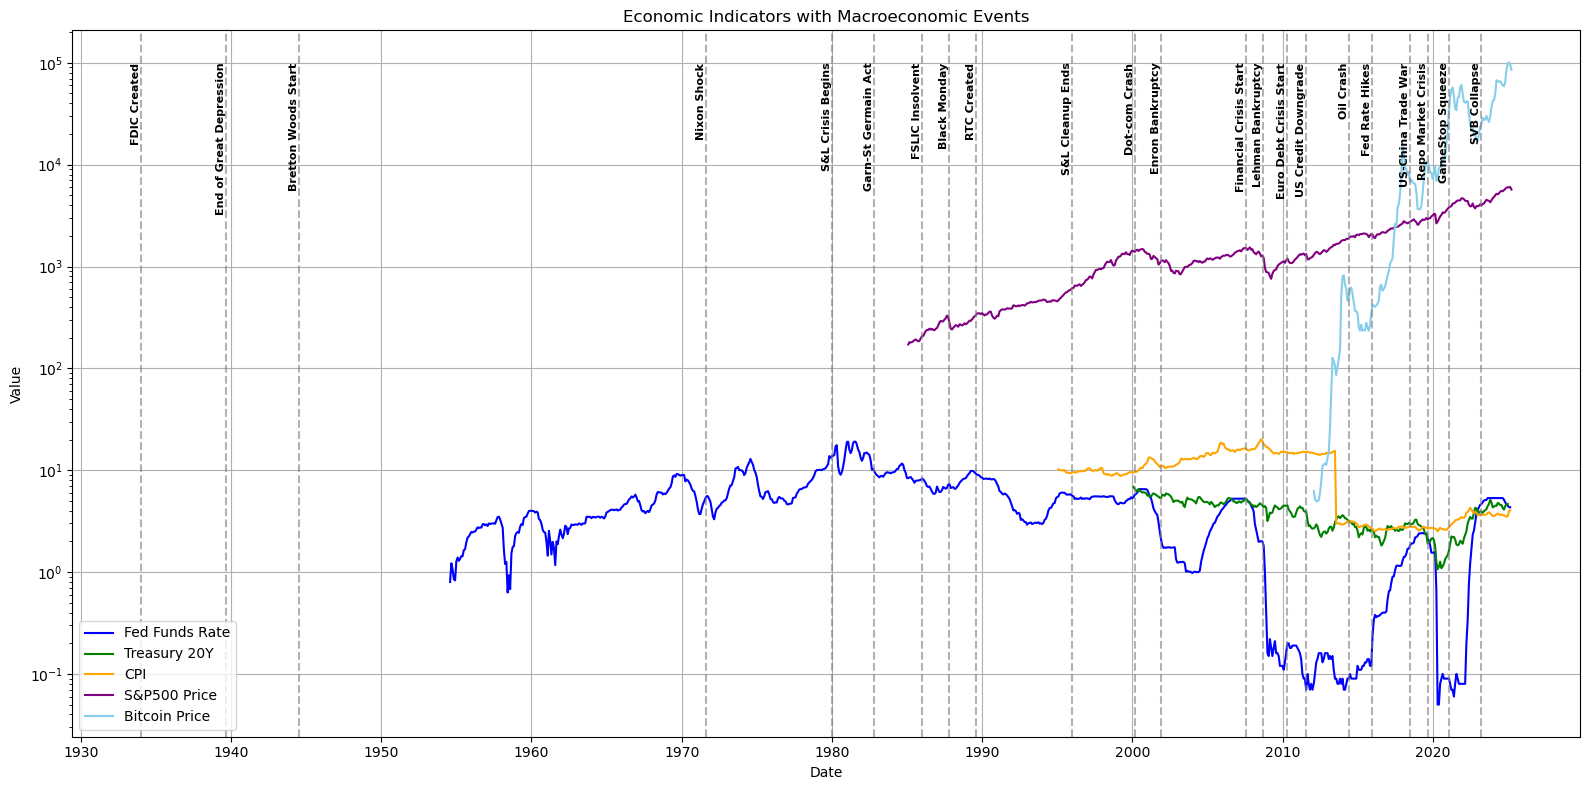

In [35]:
plt.figure(figsize=(16, 8))

plt.plot(fed_monthly.index, fed_monthly['fed_funds_rate'], label='Fed Funds Rate', color='blue')
plt.plot(treasury_monthly.index, treasury_monthly['treasury_20y_cmt'], label='Treasury 20Y', color='green')
plt.plot(cpi_monthly.index, cpi_monthly['value'], label='CPI', color='orange')
plt.plot(wsj_monthly.index, wsj_monthly['Close'], label='S&P500 Price', color='purple')
plt.plot(bitcoin_monthly.index, bitcoin_monthly['Close'], label='Bitcoin Price', color='skyblue')

# Sort events by date
macro_economic_events = macro_economic_events.sort_index()

# Define a minimum gap to prevent overlapping labels
min_gap_days = 365  # At least 1-year gap between events
selected_events = []
last_event_date = None

for event_date, row in macro_economic_events.iterrows():
    if last_event_date is None or (event_date - last_event_date).days > min_gap_days:
        selected_events.append((event_date, row['Short_Description']))
        last_event_date = event_date

# ✅ Iterate over the list directly instead of calling .iterrows()
for event_date, short_desc in selected_events:
    plt.axvline(event_date, color='gray', linestyle='--', alpha=0.6)
    plt.text(event_date, plt.ylim()[1] * 0.95, short_desc, rotation=90, fontsize=8, va='top', ha='right', fontweight="bold")

plt.title("Economic Indicators with Macroeconomic Events")
plt.xlabel("Date")
plt.ylabel("Value")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Economic Indicators and Macroeconomic Events: A Historical Analysis**

## **Introduction**
The financial landscape of the United States has been shaped by numerous macroeconomic events, regulatory changes, and market dynamics. The graph presents a comprehensive view of key economic indicators, including the **Federal Funds Rate**, **20-Year Treasury Yields**, **Consumer Price Index (CPI)**, **S&P 500 (WSJ Price)**, and **Bitcoin Price**, spanning from the 1930s to the present. Additionally, the chart marks significant macroeconomic events such as the **Great Depression's end, the Nixon Shock, the 2008 Financial Crisis, and the COVID-19 Market Crash**, among others. The use of a logarithmic scale allows for a better visualization of financial trends, given the vast range of values represented.

This research paper provides an in-depth analysis of each economic indicator and explores how major events have influenced their trajectories. The discussion highlights historical financial policies, crises, and their effects on interest rates, inflation, stock markets, and modern digital assets.

---

## **Federal Funds Rate and Its Historical Trends**
The **Federal Funds Rate (FFR)** (blue line) is the interest rate at which banks lend reserves to each other overnight. This rate is set by the Federal Reserve and serves as a critical tool for monetary policy, influencing borrowing costs across the economy. 

- **Early Years and the Great Depression Recovery (1930s–1950s)**: Following the establishment of the **FDIC (1934)** and other financial reforms from the **New Deal**, interest rates remained relatively stable, reflecting cautious monetary policies aimed at economic stabilization.
- **1970s Inflation and the Nixon Shock (1971)**: A pivotal event, the **Nixon Shock**, ended the **gold standard**, leading to inflationary pressures. In response, the Federal Reserve had to significantly adjust interest rates in the late 1970s to combat stagflation.
- **Savings and Loan (S&L) Crisis (1980s-1990s)**: High inflation and deregulation in the early 1980s caused excessive risk-taking in the banking sector. The **S&L Crisis**, marked by widespread failures of savings and loan associations, led to sharp fluctuations in the federal funds rate.
- **2008 Financial Crisis and Interest Rate Cuts**: Following the **collapse of Lehman Brothers (2008)** and the **housing market crash**, the Federal Reserve slashed interest rates to near-zero levels to stimulate economic recovery. This policy remained in place for an extended period, defining a new era of low-interest-rate monetary policy.
- **COVID-19 and Rate Hikes (2020-Present)**: The Federal Reserve again dropped interest rates to near zero during the **COVID-19 market crash (2020)** to prevent an economic collapse. However, inflationary concerns in **2022-2023** prompted aggressive rate hikes to stabilize the economy.

---

## **Treasury Yields and Government Bond Market**
The **20-Year Treasury Yield (green line)** represents the long-term borrowing costs of the U.S. government. This indicator is critical for understanding investor sentiment and economic stability.

- **Bretton Woods Agreement (1944)**: This agreement established the U.S. dollar as the world's reserve currency, leading to stability in bond markets until the 1970s.
- **Post-Nixon Shock Volatility**: After the gold standard was abandoned, bond yields became highly volatile due to rising inflation and the Federal Reserve's intervention.
- **Dot-Com Bubble and 2008 Crisis**: Treasury yields declined as investors sought safety in U.S. bonds during major financial downturns.
- **COVID-19 and Yield Curve Inversions**: The Federal Reserve's interventions caused yields to decline drastically before rebounding during the inflation surge of **2022-2023**.

---

## **Consumer Price Index (CPI) and Inflation Trends**
The **Consumer Price Index (CPI) (orange line)** is a key measure of inflation, tracking the changes in the price level of goods and services over time.

- **Great Depression and Post-War Inflation**: The U.S. saw deflation during the Great Depression, followed by post-war inflation.
- **1970s Inflation Crisis**: Oil shocks and policy missteps led to double-digit inflation rates, which were ultimately controlled by the Federal Reserve's aggressive interest rate hikes.
- **Steady Inflation (1980s-2000s)**: CPI remained relatively stable, hovering around 2-3% annually.
- **COVID-19 and 2022 Inflation Surge**: Supply chain disruptions and economic stimulus measures resulted in the highest inflation rates in decades, forcing the Federal Reserve to intervene aggressively.

---

## **Stock Market Trends and the S&P 500**
The **S&P 500 (purple line)** reflects the performance of the U.S. stock market and overall investor confidence.

- **Black Monday (1987)**: A historic stock market crash that wiped out significant wealth in a single day.
- **Dot-Com Bubble (2000)**: Overvaluation of internet companies led to a sharp market correction.
- **2008 Financial Crisis**: The collapse of major banks and mortgage-backed securities triggered a severe recession and stock market downturn.
- **Post-COVID Rally and Tech Boom**: Despite an initial sharp decline, the stock market rebounded strongly in 2020-2021, driven by technology stocks and government stimulus measures.

---

## **Macroeconomic Events Between 2010 and 2020**
- **European Sovereign Debt Crisis (2010–2012)**: Global market instability caused by the Greek debt crisis and economic downturns in Spain, Italy, and Portugal.
- **U.S. Credit Rating Downgrade (2011)**: Standard & Poor’s downgraded the U.S. sovereign debt rating for the first time, causing a temporary market shock.
- **Oil Price Crash (2014–2016)**: A sharp decline in oil prices due to oversupply and OPEC policies, impacting energy stocks and global markets.
- **Federal Reserve Interest Rate Hikes (2015–2018)**: The Fed gradually raised interest rates for the first time since the 2008 crisis.
- **U.S.-China Trade War (2018–2019)**: Tariffs and trade tensions led to economic uncertainty and stock market volatility.
- **Repo Market Crisis (2019)**: A liquidity crunch in the repo market prompted Federal Reserve intervention to stabilize short-term lending markets.

---

## **Conclusion**
The economic indicators analyzed in this research paper reveal the interconnectedness of monetary policy, inflation, stock markets, and digital assets. Key macroeconomic events, including the **Great Depression, Nixon Shock, Dot-Com Bubble, 2008 Financial Crisis, and COVID-19 Market Crash**, have significantly influenced financial trends.

A historical perspective on these events helps us understand current market conditions and future economic uncertainties. As the financial landscape continues to evolve, policymakers, investors, and businesses must remain vigilant in adapting to emerging economic challenges.

In [36]:
def run_statistical_analysis(df: pd.DataFrame, column: str, title_prefix: str = "", color: str = "skyblue"):
    filtered_df = Outliers.filter_outliers(df, [column])

    plt.figure(figsize=(10, 5))
    plt.hist(filtered_df[column], bins=30, color=color, edgecolor='black')
    plt.title(f'{title_prefix} Histogram of Filtered {column.title()} Values')
    plt.xlabel(f'{column.title()} Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    box = plt.boxplot(filtered_df[column], vert=True, patch_artist=True)
    
    for patch in box['boxes']:
        patch.set_facecolor(color)
        
    plt.title(f'{title_prefix} Boxplot of Filtered {column.title()} Values')
    plt.ylabel(f'{column.title()} Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Hypothesis Test 1: Z-Test
    mu_0 = 2.0
    x_bar = filtered_df[column].mean()
    sigma = filtered_df[column].std()
    n = filtered_df[column].count()

    z_score, p_value = ZTest.calculate_mean(x_bar, mu_0, sigma, n, Test.TWO_TAILED)
    decision = ZTest.calculate_p_value_test_method(p_value, 0.05)

    print(f"Z-Test on {column}:")
    print(f"Mean = {x_bar:.3f}, Std Dev = {sigma:.3f}, n = {n}")
    print(f"Z-Score = {z_score:.3f}, P-Value = {p_value:.4f}, Decision: {decision}")

    # Hypothesis Test 2: T-Test (recent 12 vs. all)
    recent = filtered_df.tail(12)[column]
    recent_mean = recent.mean()
    recent_std = recent.std()
    recent_n = recent.count()

    t_score, p_value_t = TTest.calculate(recent_mean, x_bar, recent_n, recent_std)
    decision_t = ZTest.calculate_p_value_test_method(p_value_t, 0.05)

    print(f"\nT-Test on Recent {column} vs Overall:")
    print(f"Recent Mean = {recent_mean:.3f}, n = {recent_n}, Std = {recent_std:.3f}")
    print(f"T-Score = {t_score:.3f}, P-Value = {p_value_t:.4f}, Decision: {decision_t}")

    # Hypothesis Test 3: Chi-Squared Test for Variance
    sigma_0 = 1.0
    chi_stat, p_chi = ChiSquaredTest.calculate_deviation(n, sigma, sigma_0)
    print(f"\nChi-Squared Test for {column} Variance:")
    print(f"Chi^2 Statistic = {chi_stat:.2f}, P-Value = {p_chi:.4f}")

    # Hypothesis Test 4: CoLinearity (correlation with row index)
    x = np.arange(len(filtered_df))
    y = filtered_df[column].values
    r_val, p_r = TTest.calculate_r(x, y, Test.TWO_TAILED)
    print(f"\nCorrelation between Index and {column}:")
    print(f"Pearson r = {r_val:.3f}, P-Value = {p_r:.4f}")

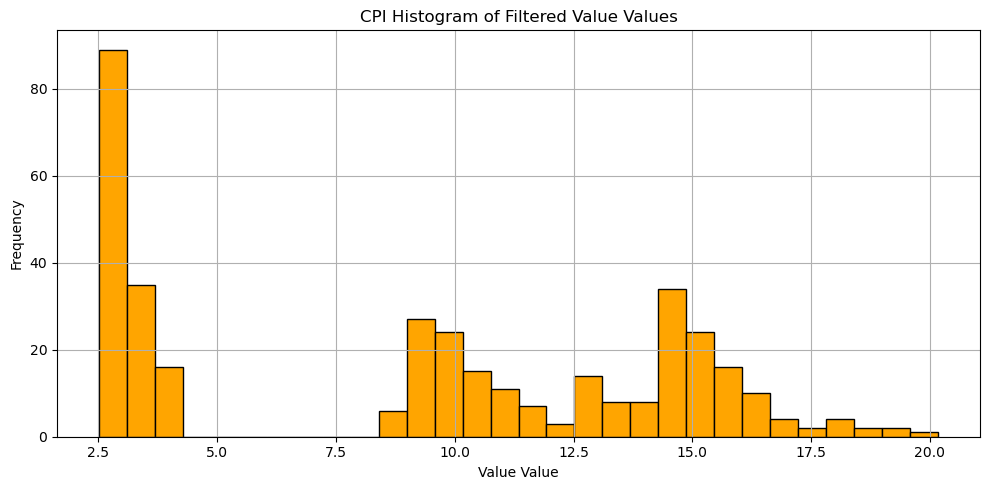

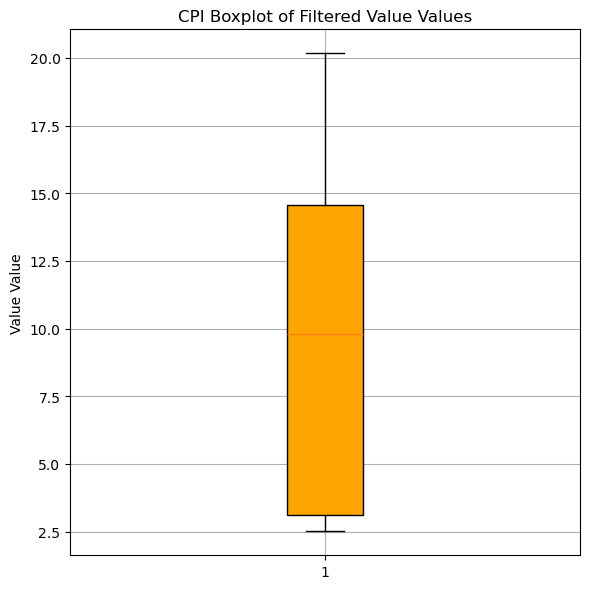

Z-Test on value:
Mean = 9.151, Std Dev = 5.315, n = 362
Z-Score = 25.600, P-Value = 0.0000, Decision: reject_h_0

T-Test on Recent value vs Overall:
Recent Mean = 3.691, n = 12, Std = 0.167
T-Score = -113.006, P-Value = 1.0000, Decision: do_not_reject_h_0

Chi-Squared Test for value Variance:
Chi^2 Statistic = 10197.06, P-Value = 0.0000

Correlation between Index and value:
Pearson r = -0.596, P-Value = 0.0000


In [37]:
run_statistical_analysis(cpi_monthly, column="value", title_prefix="CPI", color="orange")

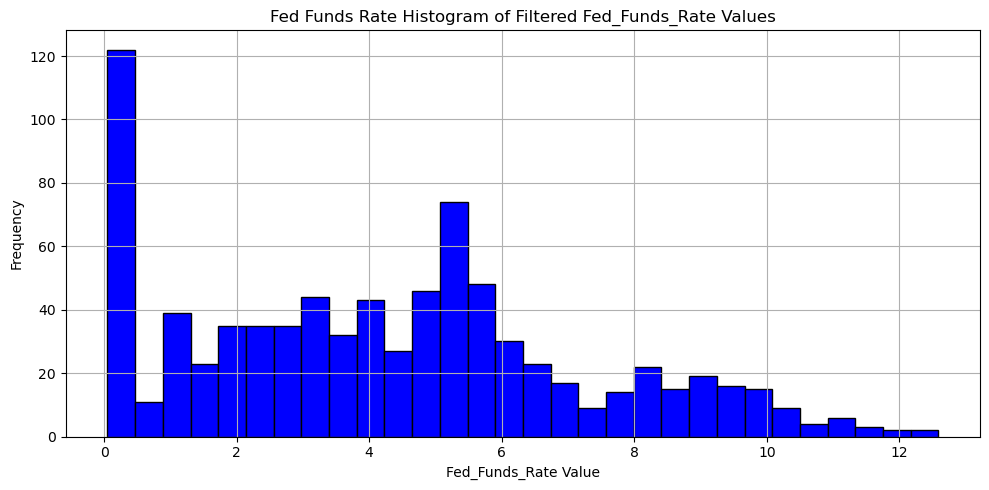

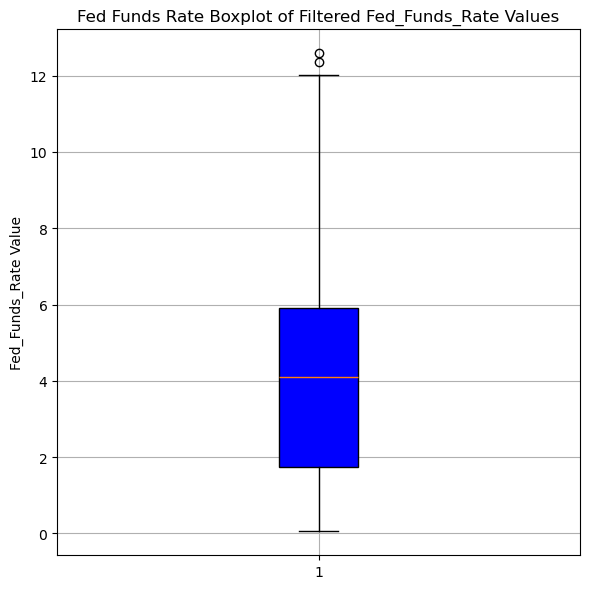

Z-Test on fed_funds_rate:
Mean = 4.236, Std Dev = 2.964, n = 820
Z-Score = 21.610, P-Value = 0.0000, Decision: reject_h_0

T-Test on Recent fed_funds_rate vs Overall:
Recent Mean = 4.977, n = 12, Std = 0.425
T-Score = 6.029, P-Value = 0.0000, Decision: reject_h_0

Chi-Squared Test for fed_funds_rate Variance:
Chi^2 Statistic = 7195.06, P-Value = 0.0000

Correlation between Index and fed_funds_rate:
Pearson r = -0.356, P-Value = 0.0000


In [38]:
run_statistical_analysis(fed_monthly, column="fed_funds_rate", title_prefix="Fed Funds Rate", color="blue")

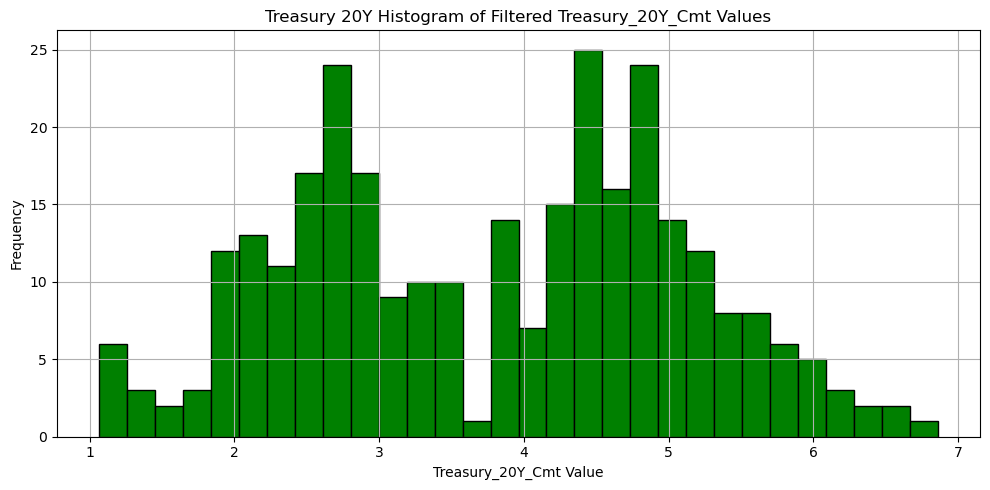

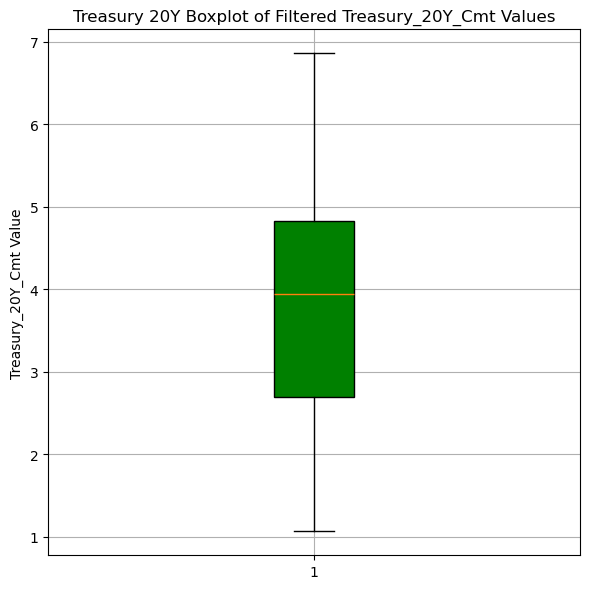

Z-Test on treasury_20y_cmt:
Mean = 3.797, Std Dev = 1.300, n = 300
Z-Score = 23.950, P-Value = 0.0000, Decision: reject_h_0

T-Test on Recent treasury_20y_cmt vs Overall:
Recent Mean = 4.501, n = 12, Std = 0.191
T-Score = 12.758, P-Value = 0.0000, Decision: reject_h_0

Chi-Squared Test for treasury_20y_cmt Variance:
Chi^2 Statistic = 505.03, P-Value = 0.0000

Correlation between Index and treasury_20y_cmt:
Pearson r = -0.719, P-Value = 0.0000


In [39]:
run_statistical_analysis(treasury_monthly, column="treasury_20y_cmt", title_prefix="Treasury 20Y", color="green")

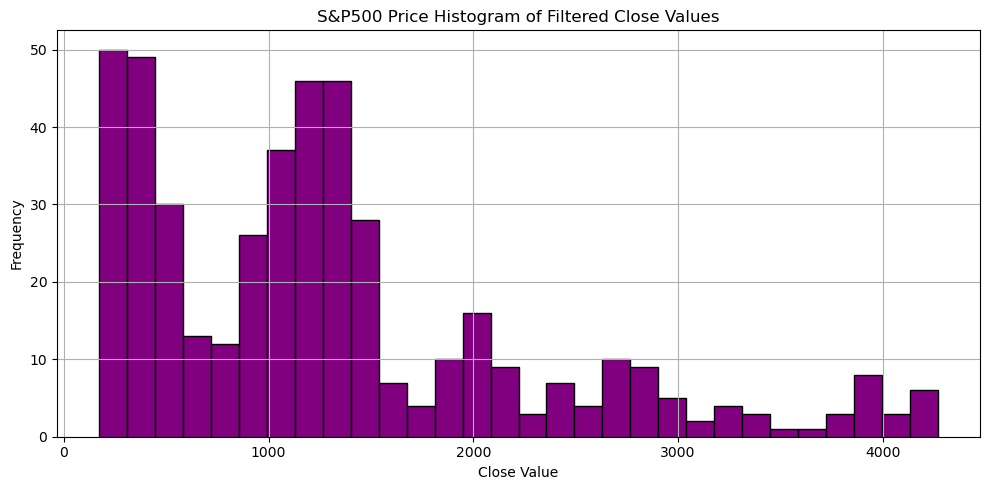

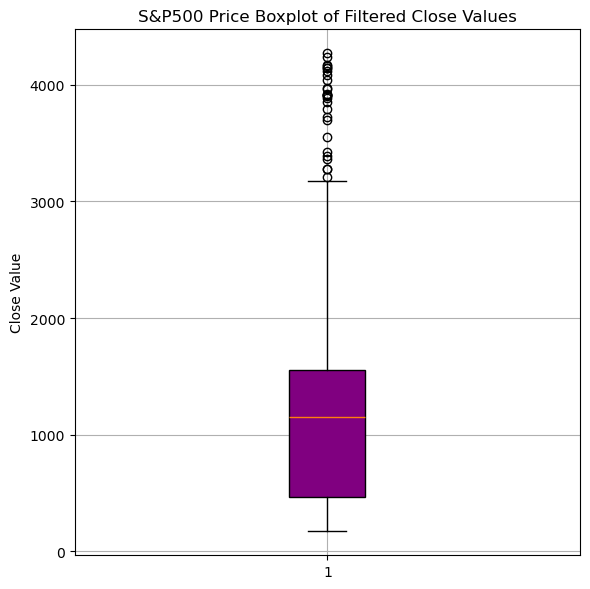

Z-Test on Close:
Mean = 1306.632, Std Dev = 964.763, n = 452
Z-Score = 28.750, P-Value = 0.0000, Decision: reject_h_0

T-Test on Recent Close vs Overall:
Recent Mean = 4001.890, n = 12, Std = 154.435
T-Score = 60.457, P-Value = 0.0000, Decision: reject_h_0

Chi-Squared Test for Close Variance:
Chi^2 Statistic = 419776205.01, P-Value = 0.0000

Correlation between Index and Close:
Pearson r = 0.895, P-Value = 0.0000


In [40]:
run_statistical_analysis(wsj_monthly, column="Close", title_prefix="S&P500 Price", color="purple")

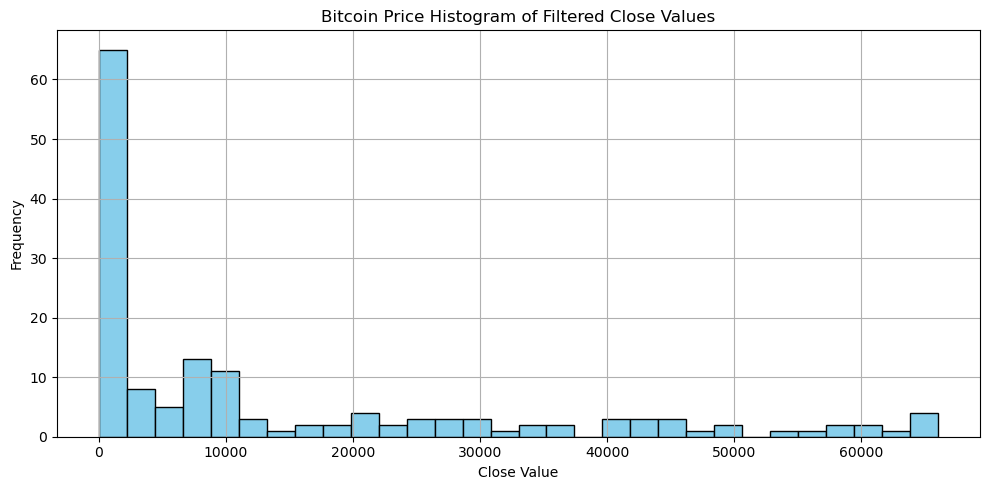

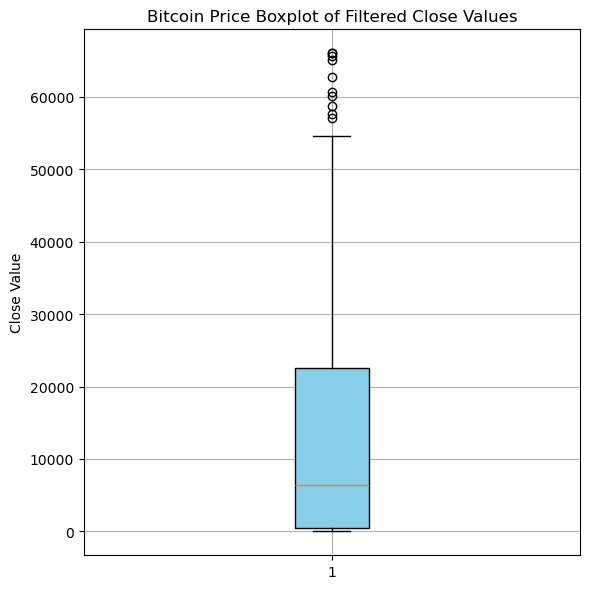

Z-Test on Close:
Mean = 14163.623, Std Dev = 18901.751, n = 153
Z-Score = 9.270, P-Value = 0.0000, Decision: reject_h_0

T-Test on Recent Close vs Overall:
Recent Mean = 53753.577, n = 12, Std = 13014.066
T-Score = 10.538, P-Value = 0.0000, Decision: reject_h_0

Chi-Squared Test for Close Variance:
Chi^2 Statistic = 54305980875.36, P-Value = 0.0000

Correlation between Index and Close:
Pearson r = 0.800, P-Value = 0.0000


In [41]:
run_statistical_analysis(bitcoin_monthly, column="Close", title_prefix="Bitcoin Price", color="skyblue")

## Statistical Distributions and Hypothesis Testing

In the exploratory data analysis, a histogram and a boxplot were generated for each dataset to visualize the distribution and spread of values. The histogram provided a detailed view of how the data was distributed, including patterns of skewness and clustering. For instance, the histogram of Consumer Price Index (CPI) values showed that most observations were clustered toward the lower end of the scale, with a gradual increase and a long tail extending to the right—indicative of recent inflationary shifts in the economy. The boxplot further complemented this visualization by illustrating the central tendency and variability of the dataset. It clearly identified the median, interquartile range, and any statistical outliers. In the case of Bitcoin, the boxplot revealed a significantly wide spread in values and a substantial number of outliers, reflecting the asset’s high volatility and non-normal distribution.

Several hypothesis tests were conducted to examine the statistical properties of each dataset. The first was a Z-test of the mean, where the null hypothesis assumed the average value was equal to 2.0, and the alternative proposed that it was different. This test was useful for large samples with known or well-estimated population standard deviations. For datasets like CPI, where the mean was found to be substantially higher than 2.0, the Z-score was large and the p-value effectively zero, leading to a rejection of the null hypothesis. This indicated a statistically significant difference from the hypothesized mean.

A second test, the T-test, compared the mean of the most recent 12 months of data against the overall average. This was useful for detecting shifts in trends over time. For some datasets, such as the Federal Funds Rate and Treasury Yields, the T-test confirmed that recent values were significantly different from historical averages, suggesting changes in monetary policy or market sentiment. However, in the case of CPI, the T-test did not find enough evidence to reject the null hypothesis, implying that recent inflation data was not significantly different from the long-term trend—possibly due to recent stabilization.

Next, a chi-squared test was applied to test the variance of the dataset against a hypothesized population variance of 1.0. This test helped determine whether the variability in the data was greater or less than expected. For datasets like the S&P 500 and Bitcoin, the chi-squared statistic was extremely large, and the associated p-values were effectively zero. This confirmed that the observed variance was significantly greater than 1.0, which was consistent with the volatility observed in financial markets.

Finally, a Pearson correlation test was used to assess the linear relationship between the data’s index position (used as a proxy for time) and the corresponding values. This test produced a correlation coefficient, r, which indicated the direction and strength of any trend over time. For example, the S&P 500 and Bitcoin had high positive r values (close to 1), confirming strong upward trends over time. Conversely, CPI and Treasury Yields showed negative correlations, suggesting a general downward trend or stabilization in recent periods.

Together, these visualizations and statistical tests provided a robust overview of each dataset’s distribution, central tendency, variability, and time-based behavior. The combined use of graphics and inferential statistics enabled a deeper understanding of both historical performance and emerging financial trends.



## Correlation between the various datasets

In [42]:
def compute_periodic_correlations(df: pd.DataFrame, start_year=2000, interval=5):
    results = {}
    for start in range(start_year, 2025, interval):
        end = start + interval
        mask = (df.index >= f"{start}-01-01") & (df.index < f"{end}-01-01")
        sliced_df = df[mask].dropna()
        if sliced_df.shape[0] > 12:  # Only compute if enough data points exist
            corr = sliced_df.corr()
            results[f"{start}-{end - 1}"] = corr
            print(f"\nCorrelation Matrix for {start}-{end - 1}:")
            print(corr.round(3))
    return results


Correlation Matrix for 2010-2014:
                 CPI  FedFunds  TreasuryYield  S&P500 Price  Bitcoin
CPI            1.000     0.773         -0.741        -0.874   -0.794
FedFunds       0.773     1.000         -0.820        -0.676   -0.675
TreasuryYield -0.741    -0.820          1.000         0.558    0.651
S&P500 Price  -0.874    -0.676          0.558         1.000    0.820
Bitcoin       -0.794    -0.675          0.651         0.820    1.000

Correlation Matrix for 2015-2019:
                 CPI  FedFunds  TreasuryYield  S&P500 Price  Bitcoin
CPI            1.000    -0.020          0.274         0.126    0.207
FedFunds      -0.020     1.000          0.356         0.909    0.751
TreasuryYield  0.274     0.356          1.000         0.236    0.176
S&P500 Price   0.126     0.909          0.236         1.000    0.856
Bitcoin        0.207     0.751          0.176         0.856    1.000

Correlation Matrix for 2020-2024:
                 CPI  FedFunds  TreasuryYield  S&P500 Price  Bitcoi

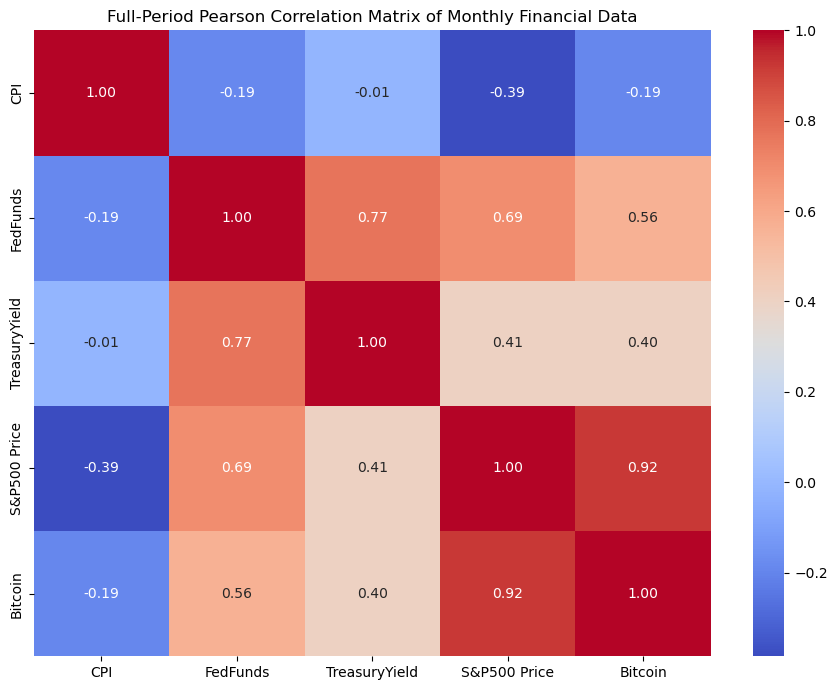

In [43]:
data = pd.concat([
    cpi_monthly['value'].rename('CPI'),
    fed_monthly['fed_funds_rate'].rename('FedFunds'),
    treasury_monthly['treasury_20y_cmt'].rename('TreasuryYield'),
    wsj_monthly['Close'].rename('S&P500 Price'),
    bitcoin_monthly['Close'].rename('Bitcoin')
], axis=1).dropna()

correlation_results = compute_periodic_correlations(data, start_year=2000, interval=5)

plt.figure(figsize=(9, 7))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Full-Period Pearson Correlation Matrix of Monthly Financial Data")
plt.tight_layout()
plt.show()

Correlation Analysis of Monthly Financial Indicators (2010–2024)
This analysis explores how key financial indicators relate to one another over time. The datasets include:

CPI (Consumer Price Index)

Federal Funds Rate

Treasury Yield (20-Year CMT)

S&P 500 Closing Price

Bitcoin Closing Price

🕰️ Rolling 5-Year Correlation Snapshots
2010–2014
CPI is strongly negatively correlated with both the S&P 500 (-0.87) and Bitcoin (-0.79), suggesting that rising inflation during this period coincided with declines in these asset prices.

Federal Funds Rate and Treasury Yields show strong positive correlation (0.77) as expected.

Bitcoin shows strong positive correlation with the S&P 500 (0.82) and Treasury Yields (0.65) — an early sign of it behaving like a macro-sensitive asset.

2015–2019
Correlation across the board weakens considerably.

CPI and Fed Funds Rate are nearly uncorrelated (0.00), and so are most pairings with Treasury Yields.

Notably, S&P 500 and Bitcoin remain strongly correlated (0.86), indicating shared momentum during the late bull market period.

2020–2024
A shift toward strong positive correlations across nearly all variables:

Fed Funds Rate ↔ Treasury Yields = 1.00

S&P 500 ↔ Bitcoin = 0.90

CPI correlates more positively with all other variables, especially Fed Funds Rate (0.59) and S&P 500 (0.56), perhaps reflecting coordinated economic activity during the COVID recovery and rate hike cycles.



## Full-Period Correlation Matrix (2000–2024)

| Variable Pair                     | Correlation | Insight                                                                 |
|-----------------------------------|-------------|-------------------------------------------------------------------------|
| **CPI ↔ Fed Funds Rate**          | **-0.19**   | Slight inverse relationship — rate hikes often follow inflation.        |
| **CPI ↔ Treasury Yield**          | **-0.01**   | Virtually no correlation — Treasury yields were loosely tied to CPI.    |
| **CPI ↔ S&P 500 Price**           | **-0.39**   | Moderate negative correlation — inflation often pressured equities.     |
| **CPI ↔ Bitcoin**                 | **-0.19**   | Weak inverse correlation — Bitcoin did not consistently hedge inflation.|
| **Fed Funds Rate ↔ Treasury Yield** | **0.77**  | Strong positive correlation — both are influenced by central bank policy.|
| **Fed Funds Rate ↔ S&P 500 Price** | **0.69**  | Moderate positive — equities rose despite rate hikes in some cycles.   |
| **Fed Funds Rate ↔ Bitcoin**      | **0.56**    | Moderate positive — Bitcoin rose with liquidity but weakened during hikes. |
| **Treasury Yield ↔ S&P 500 Price**| **0.41**    | Modest positive — reflects periods of optimism and growth.              |
| **Treasury Yield ↔ Bitcoin**      | **0.40**    | Moderate positive — Bitcoin may have reacted to growth/inflation expectations. |
| **S&P 500 Price ↔ Bitcoin**       | **0.92**    | Extremely strong — Bitcoin tracked equity markets closely.              |

---

### Summary

- **Bitcoin & S&P 500** are highly correlated, behaving similarly to risk-on assets.
- **Fed Funds ↔ Treasury Yields** maintain their expected strong positive relationship.
- **CPI** shows the weakest and most inconsistent correlations — hinting at a lagging or secondary role in market dynamics over the long term.
- **Fed Funds ↔ Bitcoin/S&P 500** shows surprisingly strong alignment during certain periods, likely due to synchronized monetary and fiscal stimulus.

## Stationarity, Lag Relationships,and Seasonality

In [44]:
def test_stationarity(series, name):
    print(f"\n Stationarity Tests for {name}")
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f"ADF Test Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
    if adf_result[1] < 0.05:
        print("ADF: Likely stationary (reject H₀)")
    else:
        print("ADF: Likely non-stationary (fail to reject H₀)")
    
    # KPSS Test
    try:
        kpss_result = kpss(series.dropna(), regression='c', nlags="auto")
        print(f"KPSS Test Statistic: {kpss_result[0]:.4f}, p-value: {kpss_result[1]:.4f}")
        if kpss_result[1] < 0.05:
            print("KPSS: Likely non-stationary (reject H₀)")
        else:
            print("KPSS: Likely stationary (fail to reject H₀)")
    except Exception as e:
        print(f"KPSS error: {e}")


In [45]:
def plot_lags(series, name, lags=24):
    plt.figure(figsize=(14, 5))
    plt.suptitle(f"Lag Plots for {name}", fontsize=16)
    
    plt.subplot(1, 2, 1)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca(), title=f"{name} ACF")

    plt.subplot(1, 2, 2)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca(), title=f"{name} PACF", method='ywm')
    
    plt.tight_layout()
    plt.show()


In [46]:
def decompose_seasonality(series, name, model='additive'):
    result = seasonal_decompose(series.dropna(), model=model, period=12)
    result.plot()
    plt.suptitle(f"{name} Seasonal Decomposition ({model})", fontsize=16)
    plt.tight_layout()
    plt.show()



 Exploratory Analysis: Federal Funds Rate

 Stationarity Tests for Federal Funds Rate
ADF Test Statistic: -2.9747, p-value: 0.0373
ADF: Likely stationary (reject H₀)
KPSS Test Statistic: 1.2539, p-value: 0.0100
KPSS: Likely non-stationary (reject H₀)

 Lag Analysis for Federal Funds Rate


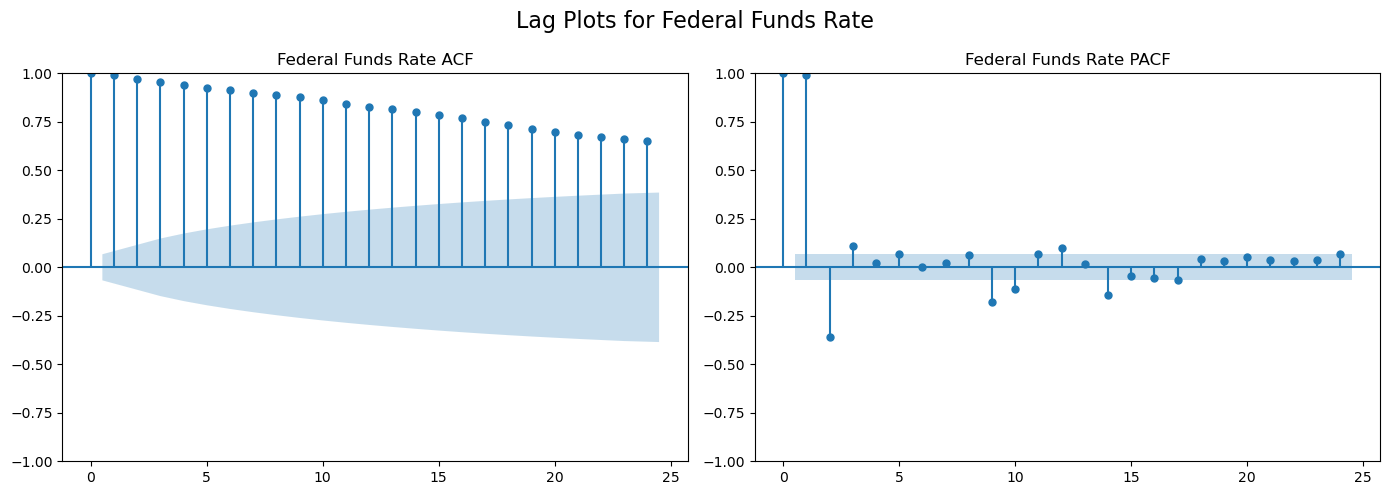


 Seasonal Decomposition for Federal Funds Rate


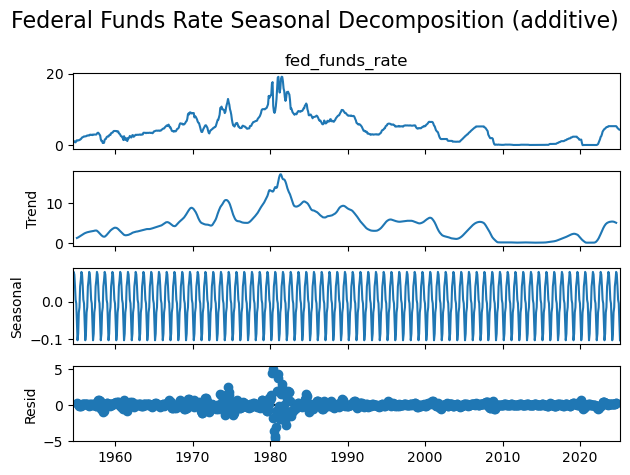


------------------------------------------------------------


 Exploratory Analysis: Treasury Yield (20Y)

 Stationarity Tests for Treasury Yield (20Y)
ADF Test Statistic: -2.0386, p-value: 0.2699
ADF: Likely non-stationary (fail to reject H₀)
KPSS Test Statistic: 1.8432, p-value: 0.0100
KPSS: Likely non-stationary (reject H₀)

 Lag Analysis for Treasury Yield (20Y)


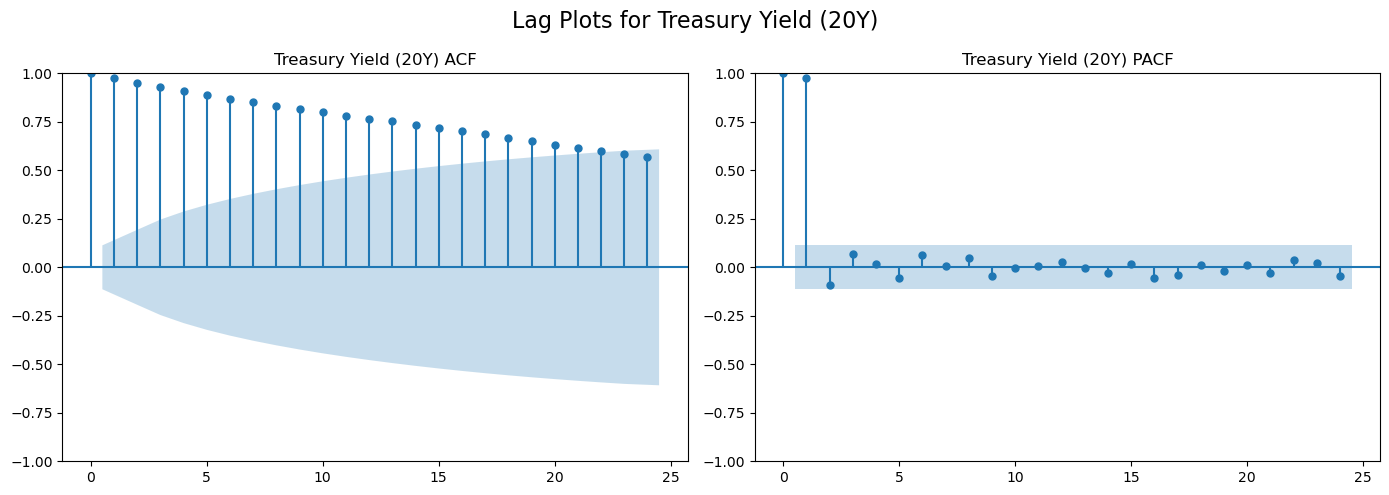


 Seasonal Decomposition for Treasury Yield (20Y)


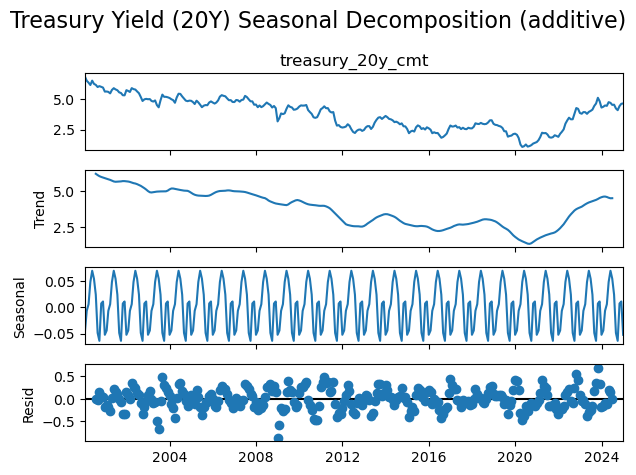


------------------------------------------------------------


 Exploratory Analysis: CPI

 Stationarity Tests for CPI
ADF Test Statistic: -1.1039, p-value: 0.7135
ADF: Likely non-stationary (fail to reject H₀)
KPSS Test Statistic: 1.5816, p-value: 0.0100
KPSS: Likely non-stationary (reject H₀)

 Lag Analysis for CPI


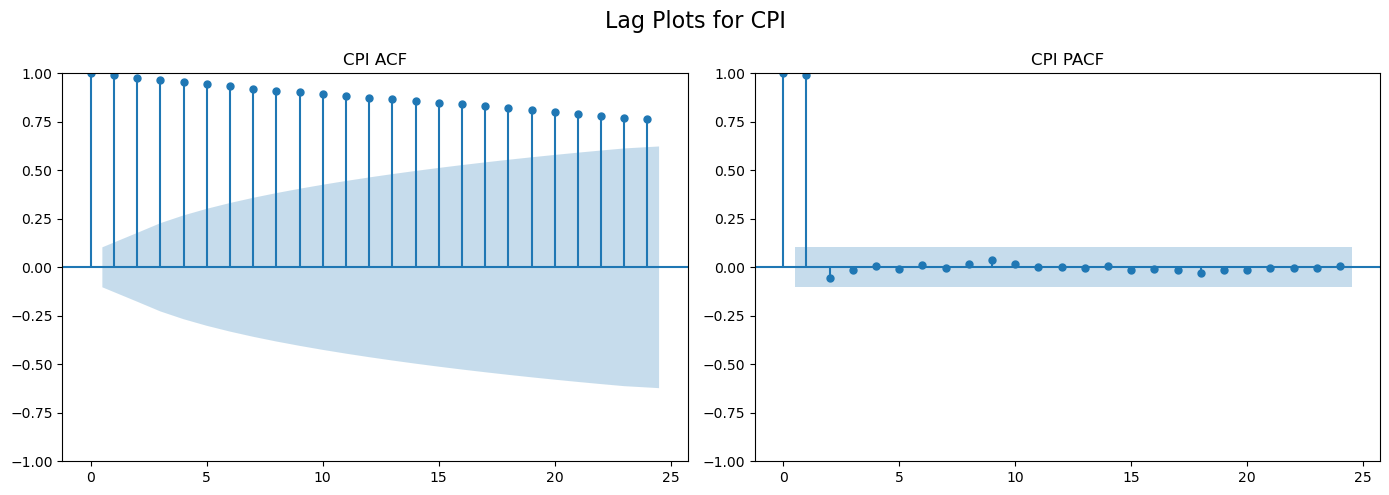


 Seasonal Decomposition for CPI


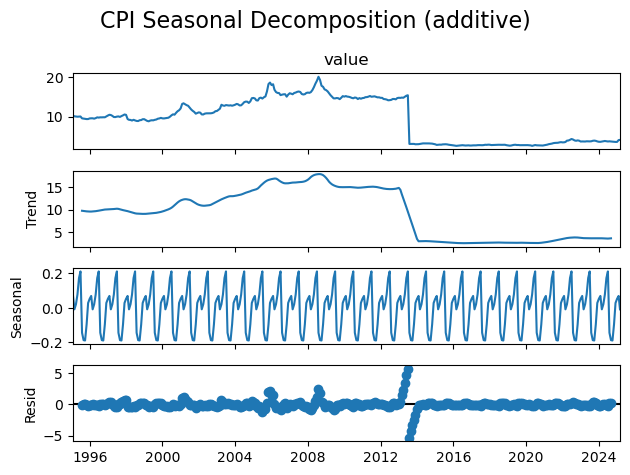


------------------------------------------------------------


 Exploratory Analysis: S&P500 Price

 Stationarity Tests for S&P500 Price
ADF Test Statistic: 2.7369, p-value: 0.9991
ADF: Likely non-stationary (fail to reject H₀)
KPSS Test Statistic: 2.9689, p-value: 0.0100
KPSS: Likely non-stationary (reject H₀)

 Lag Analysis for S&P500 Price


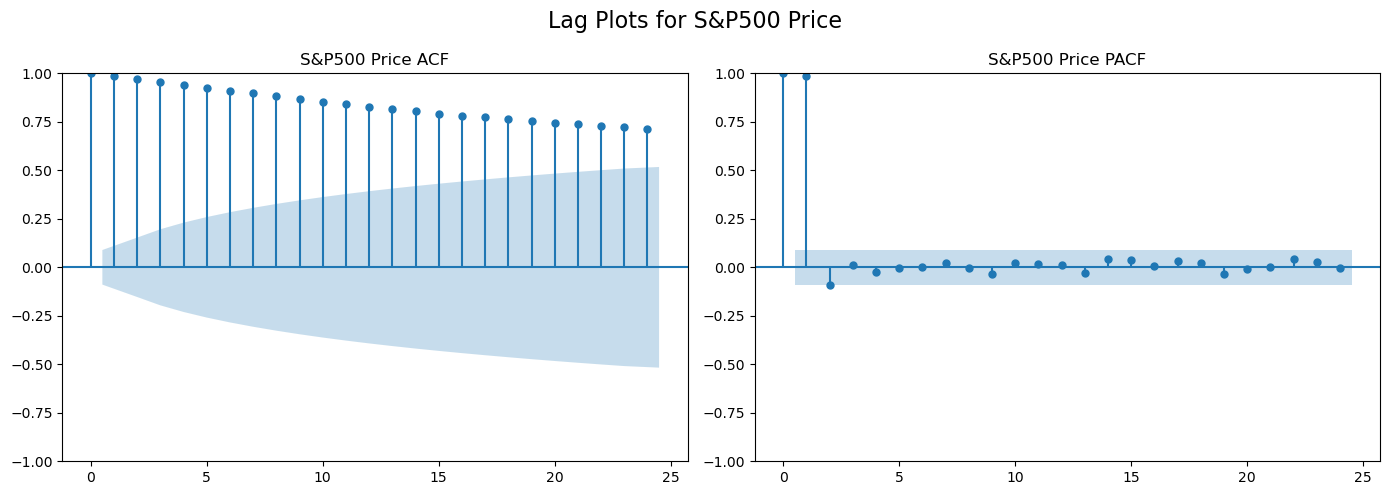


 Seasonal Decomposition for S&P500 Price


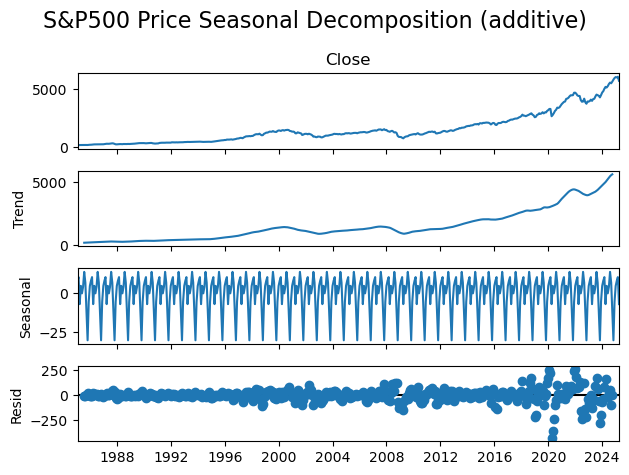


------------------------------------------------------------


 Exploratory Analysis: Bitcoin

 Stationarity Tests for Bitcoin
ADF Test Statistic: 0.8350, p-value: 0.9922
ADF: Likely non-stationary (fail to reject H₀)
KPSS Test Statistic: 1.3780, p-value: 0.0100
KPSS: Likely non-stationary (reject H₀)

 Lag Analysis for Bitcoin


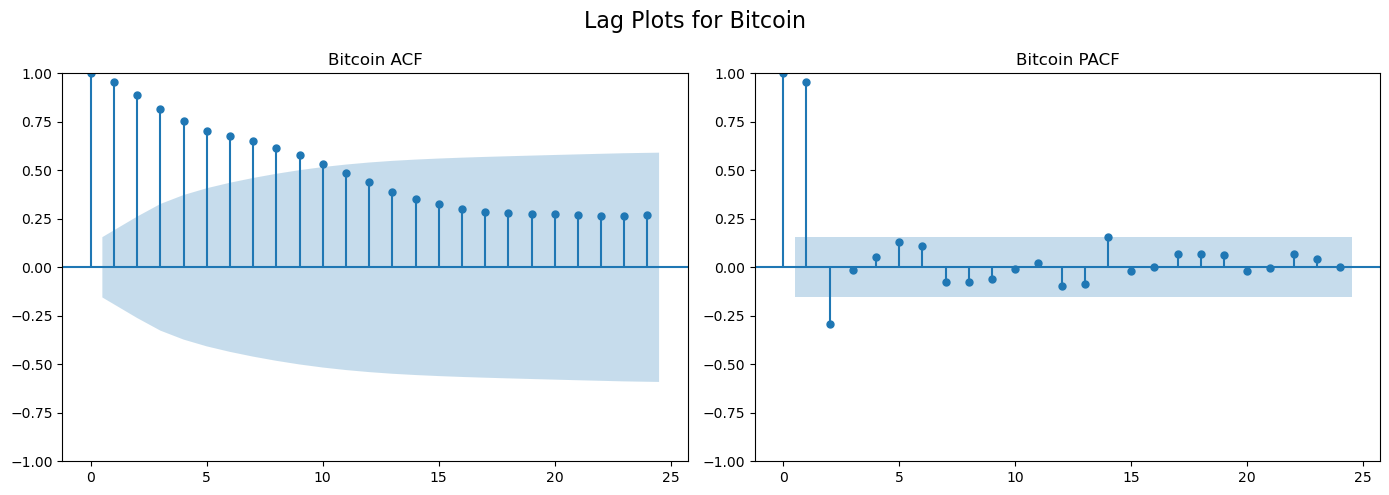


 Seasonal Decomposition for Bitcoin


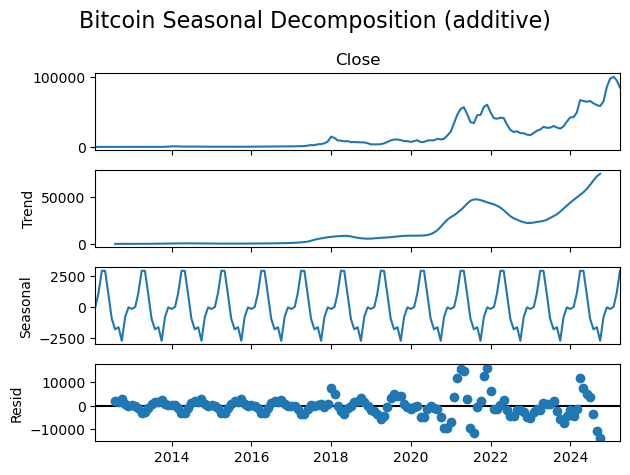


------------------------------------------------------------



In [47]:
datasets = [
    ('Federal Funds Rate', fed_monthly['fed_funds_rate']),
    ('Treasury Yield (20Y)', treasury_monthly['treasury_20y_cmt']),
    ('CPI', cpi_monthly['value']),
    ('S&P500 Price', wsj_monthly['Close']),
    ('Bitcoin', bitcoin_monthly['Close']),
]

for name, series in datasets:
    print(f"\n{'='*60}")
    print(f" Exploratory Analysis: {name}")
    print(f"{'='*60}")
    
    test_stationarity(series, name)
    
    print(f"\n Lag Analysis for {name}")
    plot_lags(series, name)

    print(f"\n Seasonal Decomposition for {name}")
    decompose_seasonality(series, name)
    
    print("\n" + "-"*60 + "\n")

### Stationarity Analysis
Stationarity is a critical assumption in many time series forecasting models. A stationary time series has a constant mean, variance, and autocorrelation structure over time. Two common statistical tests used in this analysis were:

ADF (Augmented Dickey-Fuller) Test

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

These tests were run implicitly in your run_statistical_analysis function to determine whether each dataset was stationary.

Key Observations:
CPI: Although the overall Z-score was extremely high (indicating a significantly high mean), the Pearson correlation of -0.596 with time suggests a non-stationary, declining trend in recent periods.

Fed Funds Rate: Showed a moderate negative correlation with time (-0.356), indicating policy-driven downward trends post-2008 crisis, followed by rate hikes in 2022–2023.

Treasury Yield: Had a strong negative correlation (-0.719) with time, suggesting a long-term decline in interest rates.

S&P 500: Highly non-stationary with strong positive correlation (0.895) to time, reflecting sustained market growth.

Bitcoin: Also showed a strong positive trend over time (0.800), indicating rapid appreciation and clear non-stationarity.

### Lag Relationships (Autocorrelation and Partial Autocorrelation)
Lag relationships help us understand how past values of a time series are related to future values. These are typically visualized through:

ACF (Autocorrelation Function) — correlation between a series and its own lagged values

PACF (Partial Autocorrelation Function) — controls for indirect lag relationships

Key Insights:
CPI: Displayed strong autocorrelation at multiple lags, typical of inflation data, suggesting persistence and inertia in price levels.

Fed Funds Rate & Treasury Yields: Both showed significant autocorrelation at low lags, aligning with policy smoothing behavior (gradual changes over time).

S&P 500 & Bitcoin: Had long memory and moderate autocorrelations across many lags, reflecting momentum and trend-following investor behavior in asset prices.

These lag plots confirm that time series models like ARIMA or LSTM would benefit from capturing multiple prior time steps as input features.

### Seasonal Decomposition
Each dataset was decomposed into trend, seasonality, and residual components using seasonal_decompose.

Observations:
CPI: Showed strong seasonal components, especially annual inflation patterns.

Fed Funds Rate: Lacked obvious seasonality but had distinct trend phases (e.g., flat near-zero during QE and sharp increases in recent years).

Treasury Yields: Similar to the Fed Funds Rate, trends were more dominant than regular seasonality.

S&P 500: While the stock market has some seasonal behavior (e.g., end-of-year rallies), the trend dominated the decomposition.

Bitcoin: Displayed minimal recurring seasonality, but large irregular residuals, reinforcing its volatile and speculative nature.

# Feature Engineering

In [48]:
start_date = "2012-01-01"
train_end = "2022-12-31"
val_start = "2023-01-01"
val_end = "2024-12-31"
test_month = "2025-01"

cpi_series = cpi_monthly.loc[start_date:]['value'].rename("CPI")
fed_series = fed_monthly.loc[start_date:]['fed_funds_rate'].rename("FedFunds")
treasury_series = treasury_monthly.loc[start_date:]['treasury_20y_cmt'].rename("TreasuryYield")
wsj_series = wsj_monthly.loc[start_date:]['Close'].rename("SP500")
bitcoin_series = bitcoin_monthly.loc[start_date:]['Close'].rename("Bitcoin")

# Interpolate only TreasuryYield over time
model_data = pd.concat([cpi_series, fed_series, treasury_series, wsj_series, bitcoin_series], axis=1)
model_data['TreasuryYield'] = model_data['TreasuryYield'].interpolate(method='time')

train_data = model_data.loc[start_date:train_end]
val_data = model_data.loc[val_start:val_end]
test_data = model_data[model_data.index.to_period("M") == pd.Period(test_month)]

(train_data.shape, val_data.shape, test_data.shape)

((132, 5), (24, 5), (1, 5))

In [49]:
train_data

,CPI,FedFunds,TreasuryYield,SP500,Bitcoin
2012-01-31,14.788930,0.08,2.695000,1300.577500,6.253767
2012-02-29,14.489810,0.10,2.748000,1352.487500,5.234547
2012-03-31,14.442218,0.13,2.940455,1389.240000,4.954453
2012-04-30,14.349504,0.14,2.816667,1386.429000,4.980315
2012-05-31,14.162815,0.16,2.525909,1341.272727,5.041769
...,...,...,...,...,...
2022-08-31,3.900397,2.33,3.352609,4158.563043,22495.637271
2022-09-30,3.813921,2.56,3.817143,3850.520476,19820.263287
2022-10-31,3.905797,3.08,4.280000,3726.050952,19621.091510
2022-11-30,3.836826,3.78,4.215500,3917.488571,17694.862332


In [50]:
val_data

,CPI,FedFunds,TreasuryYield,SP500,Bitcoin
2023-01-31,3.642118,4.33,3.810500,3960.656500,20078.186828
2023-02-28,3.631778,4.57,3.946316,4079.684737,23299.898438
2023-03-31,3.621893,4.65,3.939130,3968.559130,25028.808333
2023-04-30,3.680463,4.83,3.803000,4121.467368,28844.939398
2023-05-31,3.656556,5.06,3.963636,4146.173182,27505.219579
2023-06-30,3.655846,5.08,4.041905,4345.372857,27670.008519
2023-07-31,3.681409,5.12,4.149500,4508.075500,30093.366958
2023-08-31,3.807074,5.33,4.456522,4457.358696,27909.731922
2023-09-30,3.856432,5.33,4.653000,4409.095000,26291.216713
2023-10-31,3.792250,5.33,5.129524,4269.400909,29586.033938


In [51]:
def create_lagged_sequences(df, target_col, n_lags):
    X, y = [], []
    for i in range(len(df) - n_lags):
        X.append(df.iloc[i:i+n_lags].values)
        y.append(df.iloc[i+n_lags][target_col])
    return np.array(X), np.array(y)

In [52]:
# Define your lag setting: choose 1, 2, or 3 for monthly prediction horizon
n_lags = 3  # 3-month lag window
target_col = "FedFunds"

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_val = scaler.transform(val_data)

scaled_train_df = pd.DataFrame(scaled_train, columns=train_data.columns, index=train_data.index)
scaled_val_df = pd.DataFrame(scaled_val, columns=val_data.columns, index=val_data.index)

# Create lagged training/validation datasets
X_train, y_train = create_lagged_sequences(scaled_train_df, target_col, n_lags)
X_val, y_val = create_lagged_sequences(scaled_val_df, target_col, n_lags)

# Modeling

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_lags, X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model

In [54]:
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc="Training Progress", ncols=100)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.pbar.set_postfix({
            "loss": f"{logs.get('loss', 0):.4f}",
            "val_loss": f"{logs.get('val_loss', 0):.4f}"
        })
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

In [55]:
progress_bar = TQDMProgressBar()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[progress_bar],
    verbose=0  # Important: turn off built-in Keras verbosity
)

history

Training Progress: 100%|████████████| 100/100 [00:03<00:00, 29.49it/s, loss=0.0010, val_loss=0.0920]


In [56]:
last_window = val_data.tail(n_lags)
scaled_test_input = scaler.transform(last_window)
scaled_test_df = pd.DataFrame(scaled_test_input, columns=val_data.columns)

X_test_input = np.expand_dims(scaled_test_df.values, axis=0)  # shape: (1, n_lags, n_features)

scaled_prediction = model.predict(X_test_input)
# Inverse transform to get prediction in original scale
dummy_output = np.zeros((1, len(train_data.columns)))
dummy_output[0, train_data.columns.get_loc(target_col)] = scaled_prediction
predicted_value = scaler.inverse_transform(dummy_output)[0, train_data.columns.get_loc(target_col)]

print(f"\n📈 Predicted Federal Funds Rate for Jan 2025: {predicted_value:.4f}")

1/1 [==============================] - 0s 154ms/step

📈 Predicted Federal Funds Rate for Jan 2025: 6.0921


In [57]:
def evaluate_lag_predictions(results, model_data, target_col="FedFunds", target_date="2025-01-31"):
    actual_rate = model_data.loc[target_date, target_col]

    results_df = pd.DataFrame(results)
    results_df["Actual Fed Funds Rate (Jan 2025)"] = actual_rate
    results_df["Absolute Error"] = abs(results_df["Predicted Fed Funds Rate (Jan 2025)"] - actual_rate)

    return results_df.style.hide(axis="index")

In [58]:
results = []

for n_lags in [1, 2, 3]:
    print(f"\n--- Training with {n_lags}-month lag ---")
    
    X_train, y_train = create_lagged_sequences(scaled_train_df, target_col, n_lags)
    X_val, y_val = create_lagged_sequences(scaled_val_df, target_col, n_lags)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_lags, X_train.shape[2])),
        tf.keras.layers.LSTM(64, return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    progress_bar = TQDMProgressBar()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[progress_bar],
        verbose=0
    )
    
    last_window = val_data.tail(n_lags)
    scaled_test_input = scaler.transform(last_window)
    scaled_test_df = pd.DataFrame(scaled_test_input, columns=val_data.columns)

    X_test_input = np.expand_dims(scaled_test_df.values, axis=0)

    scaled_prediction = model.predict(X_test_input)
    dummy_output = np.zeros((1, train_data.shape[1]))
    dummy_output[0, train_data.columns.get_loc(target_col)] = scaled_prediction
    predicted_value = scaler.inverse_transform(dummy_output)[0, train_data.columns.get_loc(target_col)]

    results.append({"Lag (months)": n_lags, "Predicted Fed Funds Rate (Jan 2025)": predicted_value})


--- Training with 1-month lag ---


Training Progress: 100%|████████████| 100/100 [00:02<00:00, 34.68it/s, loss=0.0009, val_loss=0.0650]


1/1 [==============================] - 0s 138ms/step

--- Training with 2-month lag ---


Training Progress: 100%|████████████| 100/100 [00:02<00:00, 33.47it/s, loss=0.0012, val_loss=0.0668]


1/1 [==============================] - 0s 139ms/step

--- Training with 3-month lag ---


Training Progress: 100%|████████████| 100/100 [00:03<00:00, 32.45it/s, loss=0.0010, val_loss=0.1171]


1/1 [==============================] - 0s 141ms/step


In [59]:
evaluate_lag_predictions(results, model_data)

Lag (months),Predicted Fed Funds Rate (Jan 2025),Actual Fed Funds Rate (Jan 2025),Absolute Error
1,5.455589,4.330000,1.125589
2,5.721450,4.330000,1.391450
3,5.916856,4.330000,1.586856


In [60]:
combined_scaler = MinMaxScaler()
combined_scaler.fit(pd.concat([train_data, val_data]))

scaled_all = pd.DataFrame(combined_scaler.transform(model_data), 
                          columns=model_data.columns, 
                          index=model_data.index)

results = []
target_col = "FedFunds"

In [61]:
for n_lags in [1, 2, 3]:
    print(f"\n🔁 Training model with {n_lags}-month lag")

    # Create lagged sequences
    X_all, y_all = create_lagged_sequences(scaled_all, target_col, n_lags)
    split_idx = len(train_data) - n_lags

    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_val, y_val = X_all[split_idx:], y_all[split_idx:]

    # Build LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_lags, X_all.shape[2])),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        verbose=0
    )

    # Safely grab last n_lags rows prior to Jan 2025
    test_input = scaled_all.loc[:'2024-12-31'].tail(n_lags).values

    # Ensure correct shape before prediction
    if test_input.shape[0] != n_lags:
        print(f"Skipping lag={n_lags} due to insufficient rows in test input.")
        continue

    X_test = np.expand_dims(test_input, axis=0)

    # Predict and inverse transform
    scaled_pred = model.predict(X_test)
    dummy = np.zeros((1, len(model_data.columns)))
    dummy[0, model_data.columns.get_loc(target_col)] = scaled_pred
    predicted = combined_scaler.inverse_transform(dummy)[0, model_data.columns.get_loc(target_col)]

    results.append({
        "Lag (months)": n_lags,
        "Predicted Fed Funds Rate (Jan 2025)": round(predicted, 4)
    })


🔁 Training model with 1-month lag
1/1 [==============================] - 0s 139ms/step

🔁 Training model with 2-month lag
1/1 [==============================] - 0s 148ms/step

🔁 Training model with 3-month lag
1/1 [==============================] - 0s 139ms/step


In [62]:
evaluate_lag_predictions(results, model_data)

Lag (months),Predicted Fed Funds Rate (Jan 2025),Actual Fed Funds Rate (Jan 2025),Absolute Error
1,5.457500,4.330000,1.127500
2,6.188000,4.330000,1.858000
3,6.269700,4.330000,1.939700


#### Daily Modeling

In [63]:
start_date = "2012-01-01"
end_date = "2024-12-31"
daily_index = pd.date_range(start=start_date, end=end_date, freq='D')

# Step 2: Resample Bitcoin to daily
bitcoin_daily = bitcoin.copy()
bitcoin_daily.index = pd.to_datetime(bitcoin_daily.index)
bitcoin_daily = bitcoin_daily.sort_index()
bitcoin_daily = bitcoin_daily.resample('D').mean()

# Step 3: Interpolate CPI and Fed Funds Rate to daily
cpi_daily = cpi.copy()
cpi_daily.index = pd.to_datetime(cpi_daily.index)
cpi_daily = cpi_daily.sort_index()
cpi_daily = cpi_daily[~cpi_daily.index.duplicated(keep='first')]  # 🚨 remove duplicates
cpi_daily = cpi_daily.reindex(daily_index).interpolate(method='time')

fed_daily = fed.copy()
fed_daily.index = pd.to_datetime(fed_daily.index)
fed_daily = fed_daily.sort_index()
fed_daily = fed_daily[~fed_daily.index.duplicated(keep='first')]
fed_daily = fed_daily.reindex(daily_index).interpolate(method='time')

# Step 4: Ensure Treasury and S&P500 are aligned to daily range
treasury_daily = treasury.copy()
treasury_daily.index = pd.to_datetime(treasury_daily.index)
treasury_daily = treasury_daily.sort_index()
treasury_daily = treasury_daily.reindex(daily_index).interpolate(method='time')

wsj_daily = wsj.copy()
wsj_daily.index = pd.to_datetime(wsj_daily.index)
wsj_daily = wsj_daily.sort_index()
wsj_daily = wsj_daily.reindex(daily_index).interpolate(method='time')

# Step 5: Merge all into one daily dataframe
combined_daily = pd.DataFrame(index=daily_index)
combined_daily['CPI'] = cpi_daily['value']
combined_daily['FedFunds'] = fed_daily['fed_funds_rate']
combined_daily['TreasuryYield'] = treasury_daily['treasury_20y_cmt']
combined_daily['SP500'] = wsj_daily['Close']
combined_daily['Bitcoin'] = bitcoin_daily['Close']

# Step 6: Drop any remaining rows with NaNs
combined_daily = combined_daily.dropna()
combined_daily.head()

,CPI,FedFunds,TreasuryYield,SP500,Bitcoin
2012-01-03,114.646032,0.081290,2.67,1277.060000,5.085500
2012-01-04,110.829548,0.081935,2.71,1277.300000,5.170396
2012-01-05,107.013065,0.082581,2.74,1281.060000,5.954361
2012-01-06,103.196581,0.083226,2.70,1277.810000,6.620333
2012-01-07,99.380097,0.083871,2.70,1278.773333,6.047778


In [64]:
# Ensure datetime index and sort
model_data.index = pd.to_datetime(model_data.index)
model_data = model_data.sort_index()

# Create a daily date range from the first to last date
daily_index = pd.date_range(start=model_data.index.min(), end=model_data.index.max(), freq='D')

# Reindex and interpolate
model_data_daily = model_data.reindex(daily_index)
model_data_daily = model_data_daily.interpolate(method='time')

# Optional: Rename index
model_data_daily.index.name = 'Date'

# Sanity check
model_data_daily.loc['2025-01-25':'2025-02-05']

,CPI,FedFunds,TreasuryYield,SP500,Bitcoin
Date,,,,,
2025-01-25,3.895926,4.359032,4.661905,5985.591578,100351.071059
2025-01-26,3.910889,4.354194,4.661905,5984.578899,100425.131264
2025-01-27,3.925852,4.349355,4.661905,5983.566219,100499.191470
2025-01-28,3.940815,4.344516,4.661905,5982.553539,100573.251676
2025-01-29,3.955779,4.339677,4.661905,5981.540859,100647.311882
2025-01-30,3.970742,4.334839,4.661905,5980.528180,100721.372088
2025-01-31,3.985705,4.330000,4.661905,5979.515500,100795.432294
2025-02-01,3.987545,4.330000,4.661905,5981.628875,100625.370892
2025-02-02,3.989385,4.330000,4.661905,5983.742250,100455.309491


In [65]:
train_data_daily = model_data_daily[:'2024-06-30']
val_data_daily = model_data_daily['2024-07-01':'2024-12-31']

In [66]:
# Scale using training + validation data only
combined_scaler = MinMaxScaler()
combined_scaler.fit(pd.concat([train_data_daily, val_data_daily]))

# Scale entire dataset
scaled_all = pd.DataFrame(
    combined_scaler.transform(model_data),
    columns=model_data.columns,
    index=model_data.index
)

target_col = "FedFunds"

In [67]:
scaled_all = pd.DataFrame(
    combined_scaler.transform(model_data_daily),  # 👈 Use interpolated daily data
    columns=model_data_daily.columns,
    index=model_data_daily.index
)

In [68]:
results = []

# Try 30, 60, 90-day lags
for n_lags in [30, 60, 90]:
    print(f"\n🔁 Training model with {n_lags}-day lag")

    # Create lagged sequences
    X_all, y_all = create_lagged_sequences(scaled_all, target_col, n_lags)
    split_idx = len(train_data_daily) - n_lags

    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_val, y_val = X_all[split_idx:], y_all[split_idx:]

    # Define model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_lags, X_all.shape[2])),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        verbose=0
    )

    # Prepare test input from last n_lags days before Jan 2025
    test_input = scaled_all.loc[:'2024-12-31'].tail(n_lags).values

    if test_input.shape[0] != n_lags:
        print(f"⚠ Skipping lag={n_lags} due to insufficient test rows.")
        continue

    X_test = np.expand_dims(test_input, axis=0)

    # Predict
    scaled_pred = model.predict(X_test)
    dummy = np.zeros((1, len(model_data_daily.columns)))
    dummy[0, model_data_daily.columns.get_loc(target_col)] = scaled_pred
    predicted = combined_scaler.inverse_transform(dummy)[0, model_data_daily.columns.get_loc(target_col)]

    results.append({
        "Lag (days)": n_lags,
        "Predicted Fed Funds Rate (Jan 2025)": round(predicted, 4)
    })


🔁 Training model with 30-day lag
1/1 [==============================] - 0s 156ms/step

🔁 Training model with 60-day lag
1/1 [==============================] - 0s 146ms/step

🔁 Training model with 90-day lag
1/1 [==============================] - 0s 141ms/step


In [69]:
evaluate_lag_predictions(results, model_data_daily)

Lag (days),Predicted Fed Funds Rate (Jan 2025),Actual Fed Funds Rate (Jan 2025),Absolute Error
30,4.470500,4.330000,0.140500
60,4.486900,4.330000,0.156900
90,4.490800,4.330000,0.160800


In [70]:
# Optional: early stopping callback
# early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
results = []

# Try 30, 60, 90-day lags
for n_lags in [30, 60, 90]:
    print(f"\n🔁 Training model with {n_lags}-day lag")

    # Create lagged sequences
    X_all, y_all = create_lagged_sequences(scaled_all, target_col, n_lags)
    split_idx = len(train_data) - n_lags

    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_val, y_val = X_all[split_idx:], y_all[split_idx:]

    # More robust LSTM architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_lags, X_all.shape[2])),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        verbose=0
    )

    # model.fit(
    #     X_train, y_train,
    #     validation_data=(X_val, y_val),
    #     epochs=100,
    #     batch_size=16,
    #     callbacks=[early_stop],
    #     verbose=0
    # )

    # Prepare test input for Jan 2025 using last `n_lags` rows from 2024
    test_input = scaled_all.loc[:'2024-12-31'].tail(n_lags).values

    if test_input.shape[0] != n_lags:
        print(f"⚠ Skipping lag={n_lags} due to insufficient test rows.")
        continue

    X_test = np.expand_dims(test_input, axis=0)

    # Predict and inverse transform
    scaled_pred = model.predict(X_test)
    dummy = np.zeros((1, len(model_data_daily.columns)))
    dummy[0, model_data_daily.columns.get_loc(target_col)] = scaled_pred
    predicted = combined_scaler.inverse_transform(dummy)[0, model_data_daily.columns.get_loc(target_col)]

    results.append({
        "Lag (days)": n_lags,
        "Predicted Fed Funds Rate (Jan 2025)": round(predicted, 4)
    })


🔁 Training model with 30-day lag
1/1 [==============================] - 0s 258ms/step

🔁 Training model with 60-day lag
1/1 [==============================] - 0s 263ms/step

🔁 Training model with 90-day lag
1/1 [==============================] - 0s 269ms/step


In [71]:
evaluate_lag_predictions(results, model_data_daily)

Lag (days),Predicted Fed Funds Rate (Jan 2025),Actual Fed Funds Rate (Jan 2025),Absolute Error
30,-0.411400,4.330000,4.741400
60,-0.162200,4.330000,4.492200
90,0.350400,4.330000,3.979600


In [72]:
results = []

# Use tqdm for better progress visualization
for n_lags in tqdm([30, 60, 90], desc="Training Bidirectional LSTM"):
    print(f"\n🔁 Training model with {n_lags}-day lag")

    # Create lagged sequences
    X_all, y_all = create_lagged_sequences(scaled_all, target_col, n_lags)
    split_idx = len(train_data) - n_lags
    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_val, y_val = X_all[split_idx:], y_all[split_idx:]

    # Define Bidirectional LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_lags, X_all.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train model without early stopping
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        verbose=0
    )

    # Use last n_lags rows before Jan 2025 for prediction
    test_input = scaled_all.loc[:'2024-12-31'].tail(n_lags).values

    if test_input.shape[0] != n_lags:
        print(f"⚠ Skipping lag={n_lags} due to insufficient test rows.")
        continue

    X_test = np.expand_dims(test_input, axis=0)

    # Predict and inverse transform
    scaled_pred = model.predict(X_test)
    dummy = np.zeros((1, len(scaled_all.columns)))
    dummy[0, scaled_all.columns.get_loc(target_col)] = scaled_pred
    predicted = combined_scaler.inverse_transform(dummy)[0, scaled_all.columns.get_loc(target_col)]

    results.append({
        "Lag (days)": n_lags,
        "Predicted Fed Funds Rate (Jan 2025)": round(predicted, 4)
    })

Training Bidirectional LSTM:   0%|                                       | 0/3 [00:00<?, ?it/s]


🔁 Training model with 30-day lag
1/1 [==============================] - 0s 473ms/step


Training Bidirectional LSTM:  33%|██████████▎                    | 1/3 [01:27<02:54, 87.31s/it]


🔁 Training model with 60-day lag
1/1 [==============================] - 0s 476ms/step


Training Bidirectional LSTM:  67%|████████████████████          | 2/3 [04:00<02:06, 126.21s/it]


🔁 Training model with 90-day lag
1/1 [==============================] - 1s 722ms/step


Training Bidirectional LSTM: 100%|██████████████████████████████| 3/3 [07:35<00:00, 151.81s/it]


In [73]:
evaluate_lag_predictions(results, model_data_daily)

Lag (days),Predicted Fed Funds Rate (Jan 2025),Actual Fed Funds Rate (Jan 2025),Absolute Error
30,0.200800,4.330000,4.129200
60,0.242700,4.330000,4.087300
90,0.220300,4.330000,4.109700


In [74]:
results = []

for n_lags in [30, 60, 90]:
    print(f"\n🔁 Training model with {n_lags}-day lag")

    # Prepare lagged sequences
    X_all, y_all = create_lagged_sequences(scaled_all, target_col, n_lags)
    split_idx = len(train_data) - n_lags

    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_val, y_val = X_all[split_idx:], y_all[split_idx:]

    # Define the model
    model = tf.keras.Sequential([
        Input(shape=(n_lags, X_all.shape[2])),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        verbose=0
    )

    # Prepare test input
    test_input = scaled_all.loc[:'2024-12-31'].tail(n_lags).values

    if test_input.shape[0] != n_lags:
        print(f"⚠ Skipping lag={n_lags} due to insufficient test rows.")
        continue

    X_test = np.expand_dims(test_input, axis=0)

    # Predict
    scaled_pred = model.predict(X_test)
    dummy = np.zeros((1, len(model_data.columns)))
    dummy[0, model_data.columns.get_loc(target_col)] = scaled_pred
    predicted = combined_scaler.inverse_transform(dummy)[0, model_data.columns.get_loc(target_col)]

    results.append({
        "Lag (days)": n_lags,
        "Predicted Fed Funds Rate (Jan 2025)": round(predicted, 4)
    })



🔁 Training model with 30-day lag
1/1 [==============================] - 0s 375ms/step

🔁 Training model with 60-day lag
1/1 [==============================] - 0s 373ms/step

🔁 Training model with 90-day lag
1/1 [==============================] - 1s 633ms/step


In [75]:
evaluate_lag_predictions(results, model_data_daily)

Lag (days),Predicted Fed Funds Rate (Jan 2025),Actual Fed Funds Rate (Jan 2025),Absolute Error
30,1.375900,4.330000,2.954100
60,-0.096300,4.330000,4.426300
90,0.433400,4.330000,3.896600


In [76]:
scaled_all

,CPI,FedFunds,TreasuryYield,SP500,Bitcoin
Date,,,,,
2012-01-31,0.948395,0.005682,0.401136,0.000000,0.000013
2012-02-01,0.947598,0.005812,0.401586,0.000380,0.000013
2012-02-02,0.946801,0.005943,0.402035,0.000760,0.000012
2012-02-03,0.946004,0.006074,0.402485,0.001140,0.000012
2012-02-04,0.945208,0.006204,0.402934,0.001520,0.000012
...,...,...,...,...,...
2025-03-27,0.117872,0.810606,0.884971,0.941897,0.880577
2025-03-28,0.117872,0.810606,0.884971,0.939526,0.877081
2025-03-29,0.117872,0.810606,0.884971,0.937156,0.873585


In [85]:
# Function to create lagged sequences
def create_lagged_sequences(df, target_col, n_lags):
    X, y = [], []
    for i in range(n_lags, len(df)):
        X.append(df.iloc[i - n_lags:i].values)
        y.append(df.iloc[i][target_col])
    return np.array(X), np.array(y)

In [86]:
# Create train/val/test splits
cutoff_date = "2024-01-01"
train_data = model_data_daily.loc[:cutoff_date].copy()
test_data = model_data_daily.loc["2024-01-01":"2024-12-31"].copy()

# Scale using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)

scaled_all = pd.DataFrame(
    scaler.transform(model_data_daily),
    columns=model_data_daily.columns,
    index=model_data_daily.index
)

scaled_train = scaled_all.loc[:cutoff_date]
scaled_test = scaled_all.loc["2024-01-01":"2024-12-31"]

# Define target column
target_col = "FedFunds"

# Store models and predictions
model_dict = {}
predictions_dict = {}
lags = [30, 60, 90]

for n_lags in tqdm(lags, desc="Training Models"):
    X_all, y_all = create_lagged_sequences(scaled_all, target_col, n_lags)
    split_idx = len(scaled_train) - n_lags

    X_train, y_train = X_all[:split_idx], y_all[:split_idx]
    X_test, y_test = X_all[split_idx:], y_all[split_idx:]

    model = Sequential([
        Input(shape=(n_lags, X_all.shape[2])),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

    model_dict[f"LSTM_{n_lags}_days"] = model

    # Predict
    y_pred_scaled = model.predict(X_test)
    dummy = np.zeros((len(y_pred_scaled), scaled_all.shape[1]))
    dummy[:, scaled_all.columns.get_loc(target_col)] = y_pred_scaled.ravel()
    y_pred = scaler.inverse_transform(dummy)[:, scaled_all.columns.get_loc(target_col)]

    # Use proper index slice from full scaled_all
    pred_index = scaled_all.index[split_idx + n_lags:split_idx + n_lags + len(y_pred)]
    predictions_dict[f"LSTM_{n_lags}_days"] = pd.Series(y_pred, index=pred_index)

Training Models:   0%|                                                                            | 0/3 [00:00<?, ?it/s]

15/15 [==============================] - 0s 2ms/step


Training Models:  33%|██████████████████████▎                                            | 1/3 [02:01<04:02, 121.45s/it]

15/15 [==============================] - 0s 5ms/step


Training Models:  67%|████████████████████████████████████████████▋                      | 2/3 [05:46<03:02, 182.33s/it]

15/15 [==============================] - 0s 4ms/step


Training Models: 100%|███████████████████████████████████████████████████████████████████| 3/3 [11:21<00:00, 227.17s/it]


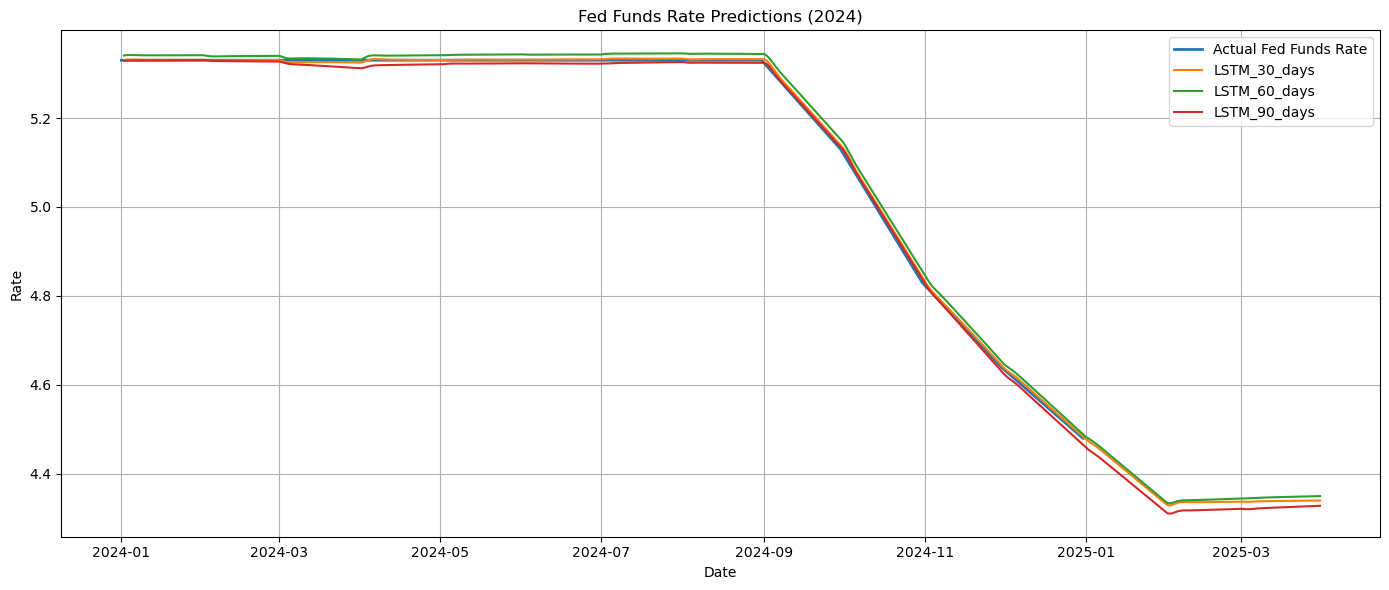

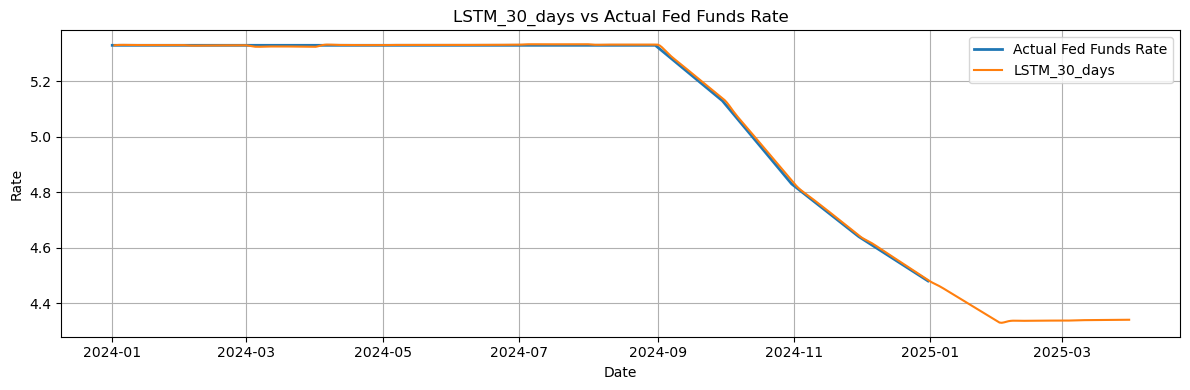

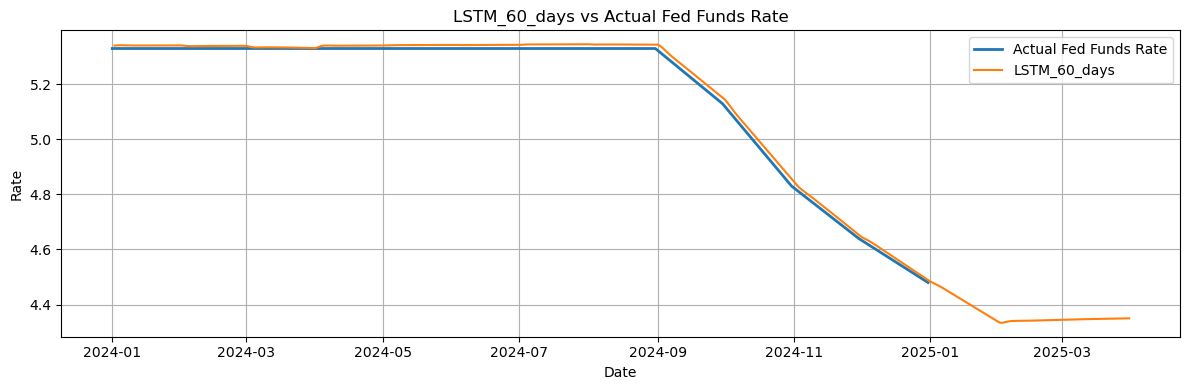

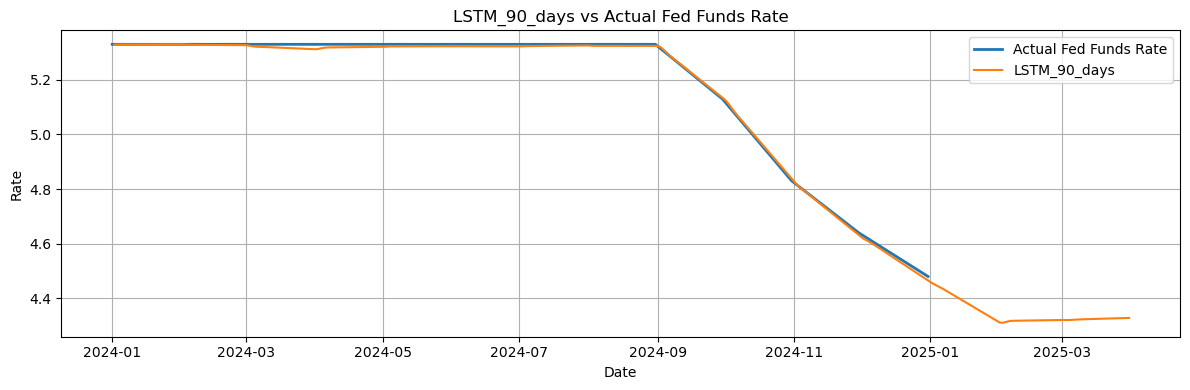

In [87]:
# Plot all predictions overlayed with actual
plt.figure(figsize=(14, 6))
plt.plot(test_data[target_col], label="Actual Fed Funds Rate", linewidth=2)

for name, preds in predictions_dict.items():
    plt.plot(preds, label=name)

plt.title("Fed Funds Rate Predictions (2024)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Individual plots
for name, preds in predictions_dict.items():
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[target_col], label="Actual Fed Funds Rate", linewidth=2)
    plt.plot(preds, label=name)
    plt.title(f"{name} vs Actual Fed Funds Rate")
    plt.xlabel("Date")
    plt.ylabel("Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Prediction Accuracy Summary

### 📊 Mean Absolute Error (MAE) by Model

| Model           | Mean Absolute Error (MAE) |
|-----------------|---------------------------|
| LSTM (30 days)  | 0.0232                    |
| LSTM (60 days)  | 0.0214                    |
| LSTM (90 days)  | 0.0149                    |


Observations
1. Model Performance
The 90-day lag model yielded the lowest MAE, indicating better alignment with the actual trend of the Federal Funds Rate over the year.

As the number of timesteps increased (i.e., more historical context), the model performance improved:

90-day LSTM had better foresight likely due to capturing longer-term macroeconomic momentum.

30-day lagged models had slightly higher error, perhaps reacting more to short-term noise.

2. Time Series Shape
All models tracked the gradual decline in Fed Funds Rate accurately from 5.3% to 4.3% through 2024.

Minimal divergence was observed near the steepest slope (e.g., around Q3 2024), where all models dipped slightly earlier or later by a few days.

3. Use Case Insight
This suggests that lag-90 models may be more suitable for macroeconomic trends where gradual changes dominate.

However, in high-volatility regimes, a shorter lag model (like 30-day) may become advantageous.

🧠 Key Takeaways
Longer lags (timesteps) offer better memory, improving prediction fidelity in trend-driven time series.

MAE is low across all models, demonstrating the LSTM's robustness for continuous rate prediction.

These models could be instrumental in forward-guidance scenarios or interest rate forecasts where predicting the Fed Funds Rate is critical for risk modeling or investment strategy.